In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

import statistics

import joblib

from sklearn.inspection import plot_partial_dependence

# Function

In [2]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [3]:
def plot_cm(cm_val, save=False, title="-", split="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(title+" {}".format(split), fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(save, split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')  
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
def predict_set(split,param):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    loaded_model = joblib.load('ensemble_model/ensemble_{}.joblib'.format(split))
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    return y_val, y_pred_val, y_pred_val_raw
def ROC_split(param):
    split = "split1"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split2"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc2 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split3"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr3, tpr3, thr3 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc3 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split4"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr4, tpr4, thr4 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc4 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    split = "split5"
    y_val, y_pred_val, y_pred_val_raw = predict_set(split,param)
    fpr5, tpr5, thr5 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc5 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc3)
    print("AUC split4: %.2f%%" % auc4)
    print("AUC split5: %.2f%%" % auc5)
    
    plt.plot(fpr1,tpr1,label="ROC split 1, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC split 2, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr3,tpr3,label="ROC split 3, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr4,tpr4,label="ROC split 4, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr5,tpr5,label="ROC split 5, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [4]:
def evaluate(param,split):
    loaded_model = joblib.load('ensemble_model/ensemble_{}.joblib'.format(split))
    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, title="Validate", split=split)
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test, title="Test", split=split)

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    # feature_impotance(split)
    # print("false_predict")
    false_predict_df(y_val, y_pred_val)
    false_predict(y_val, y_pred_val,split)
    return cm_val,cm_test,auc1,auc2

In [5]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [6]:
# def feature_impotance(split):
#     loaded_model = joblib.load('ensemble_model/ensemble_{}.joblib'.format(split))
#     path = "../kitt/DATA_progress3/"
#     train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
#     train_data = pd.read_csv(train_path)
#     x_train = train_data[train_data.columns[2:]]
#     # get the best random forest model
#     # best_rfc = loaded_model.best_estimator_
#     # get the feature importances of the best random forest model
#     importances = loaded_model.feature_importances_
#     df = pd.DataFrame({'Variable':x_train.columns,
#               'Importance':importances}).sort_values('Importance', ascending=False)
#     print(df)

In [7]:
def false_predict_df(y_true, y_pred):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3_new/"
    test_path =  "{}/test.csv".format(path)
    test_data = pd.read_csv(test_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(test_data.loc[false_indices])
    return false_indices
def false_predict(y_true, y_pred, split="test"):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3/"
    false_positive = []
    false_negative = []
    if split == "test":
        train_path = "{}/train.csv".format(path)
        train_data = pd.read_csv(train_path)
    else:
        train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
        train_data = pd.read_csv(train_path)
    if split == "test":
        test_path =  "{}/test.csv".format(path)
        test_data = pd.read_csv(test_path)
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = test_data.loc[false_positive]
        false_negative_df = test_data.loc[false_negative]
        M_data = train_data[train_data["diagnosis"]=="M"]
        B_data = train_data[train_data["diagnosis"]=="B"]
    elif "split" in split:
        val_path =  "{}/{}/val/val.csv".format(path,split)
        val_data = pd.read_csv(val_path)
        false_indices = []
        for i in range(len(y_true)):
            if y_true[i] != y_pred[i]:
                if y_pred[i] == 1:
                    false_positive.append(i)
                if y_pred[i] == 0:
                    false_negative.append(i)
        false_positive_df = val_data.loc[false_positive]
        false_negative_df = val_data.loc[false_negative]
        M_data = train_data[train_data["diagnosis"]=="M"]
        B_data = train_data[train_data["diagnosis"]=="B"]
    x_col, y_col = "area_mean" , "concavity_mean"
    # Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
    plt.scatter(B_data[x_col], B_data[y_col], color='blue', label='True Negative', alpha=0.5)
    plt.scatter(M_data[x_col], M_data[y_col], color='green', label='True Positive', alpha=0.5)
    plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='yellow', label='False Negative Predictions')
    plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='red', label='False Positive Predictions') 
    # Add legend and labels
    plt.legend()
    plt.title(split)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # Show the plot
    plt.show()

In [8]:
# def false_predict(y_true, y_pred, split="test"):
#     """
#     Compares two arrays and returns the indices of false predictions.
#     Args:
#         y_true: true labels
#         y_pred: predicted labels
#     Returns:
#         The indices of false predictions.
#     """
#     path = "../kitt/DATA_progress3/"
#     false_positive = []
#     false_negative = []
#     train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
#     train_data = pd.read_csv(train_path)
#     if split == "test":
#         test_path =  "{}/test.csv".format(path)
#         test_data = pd.read_csv(test_path)
#         for i in range(len(y_true)):
#             if y_true[i] != y_pred[i]:
#                 if y_pred[i] == 1:
#                     false_positive.append(i)
#                 if y_pred[i] == 0:
#                     false_negative.append(i)
#         false_positive_df = test_data.loc[false_positive]
#         false_negative_df = test_data.loc[false_negative]
#         M_data = train_data[train_data["diagnosis"]=="M"]
#         B_data = train_data[train_data["diagnosis"]=="B"]
#     elif "split" in split:
#         val_path =  "{}/{}/val/val.csv".format(path,split)
#         val_data = pd.read_csv(val_path)
#         false_indices = []
#         for i in range(len(y_true)):
#             if y_true[i] != y_pred[i]:
#                 if y_pred[i] == 1:
#                     false_positive.append(i)
#                 if y_pred[i] == 0:
#                     false_negative.append(i)
#         false_positive_df = val_data.loc[false_positive]
#         false_negative_df = val_data.loc[false_negative]
#         M_data = train_data[train_data["diagnosis"]=="M"]
#         B_data = train_data[train_data["diagnosis"]=="B"]
#     x_col, y_col = feature_impotance(split)
#     # Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
#     plt.scatter(B_data[x_col], B_data[y_col], color='blue', label='True Negative', alpha=0.5)
#     plt.scatter(M_data[x_col], M_data[y_col], color='green', label='True Positive', alpha=0.5)
#     plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='yellow', label='False Negative Predictions')
#     plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='red', label='False Positive Predictions') 
#     # Add legend and labels
#     plt.legend()
#     plt.title(split)
#     plt.xlabel(x_col)
#     plt.ylabel(y_col)
#     # Show the plot
#     plt.show()
    
# #     # create a joint plot with a regression line
# #     jp = sns.jointplot(x[x_col], x[y_col], kind='reg', data=df)

# #     # add distribution plots
# #     sns.histplot(x[x_col], ax=jp.ax_marg_x, color='purple')
# #     sns.histplot(x[y_col], ax=jp.ax_marg_y, color='orange')

# #     # set x and y labels
# #     jp.set_axis_labels(x_col, y_col)

# #     # show the plot
# #     plt.show()

#     return false_indices

# Grid Search

In [9]:
# def RF_GridSearch(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     param_dist = {
#     'n_estimators': [100,150,200],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [5,10,20],
#     'min_samples_split': [2,5,10],
#     'min_samples_leaf': [1,5,10],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
#     }

#     # Define grid search object
#     cv_rf = GridSearchCV(RandomForestClassifier(), param_dist)

#     cv_rf.fit(x_train, y_train)

#     # save the model
#     path = 'RF_model/RF_parameter_{}.txt'.format(split)
#     with open(path, 'w') as f:
#         f.write(str(cv_rf.best_params_)+"\n")
#         f.write(str(cv_rf.best_score_))
#         print("save parameter at {}".format(path))
#     joblib.dump(cv_rf, 'RF_model/RF_{}.joblib'.format(split))

In [10]:
# RF_GridSearch("split1")
# RF_GridSearch("split2")
# RF_GridSearch("split3")
# RF_GridSearch("split4")
# RF_GridSearch("split5")

In [11]:
# def Ensemble_train(split):
#     x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
#     # Define model
#     # SVM param
#     svm = SVC(C=100, gamma=0.001, kernel='rbf',probability=True)
    
#     # LR param5
#     lr = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
    
#     # DT param1
#     dt = DecisionTreeClassifier(criterion="entropy",
#                          max_depth=15, min_samples_leaf=1, 
#                          min_samples_split=3, splitter="random")
    
#     # SGD param4
#     sgd = SGDClassifier(loss='log', penalty='l2', learning_rate='optimal', eta0=0.01, max_iter=1000, alpha=0.01)
   
#     # RF param4
#     # {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
#     rf = RandomForestClassifier(bootstrap=True, 
#                         criterion="entropy", 
#                         max_depth=10, 
#                         max_features="log2", 
#                         min_samples_leaf=1, 
#                         min_samples_split=5, 
#                         n_estimators=100)
    
#     svm.fit(x_train, y_train)
#     lr.fit(x_train, y_train)
#     dt.fit(x_train, y_train)
#     sgd.fit(x_train, y_train)
#     rf.fit(x_train,y_train)
    
#     # create the voting ensemble model
#     ensemble = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('dt', dt), ('sgd', sgd), ('rf', rf)], voting='soft')
#     ensemble.fit(x_train, y_train)
#     # save the model
#     joblib.dump(ensemble, 'ensemble_model/ensemble_{}.joblib'.format(split))

In [12]:

# Ensemble_train("split1")
# Ensemble_train("split2")
# Ensemble_train("split3")
# Ensemble_train("split4")
# Ensemble_train("split5")

In [13]:
# RF_param1("split1")
# RF_param1("split2")
# RF_param1("split3")
# RF_param1("split4")
# RF_param1("split5")

# RF_param2("split1")
# RF_param2("split2")
# RF_param2("split3")
# RF_param2("split4")
# RF_param2("split5")

# RF_param3("split1")
# RF_param3("split2")
# RF_param3("split3")
# RF_param3("split4")
# RF_param3("split5")

# RF_param4("split1")
# RF_param4("split2")
# RF_param4("split3")
# RF_param4("split4")
# RF_param4("split5")

# RF_param5("split1")
# RF_param5("split2")
# RF_param5("split3")
# RF_param5("split4")
# RF_param5("split5")

# Setting Split 1

In [14]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split1

############## validate set ################
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


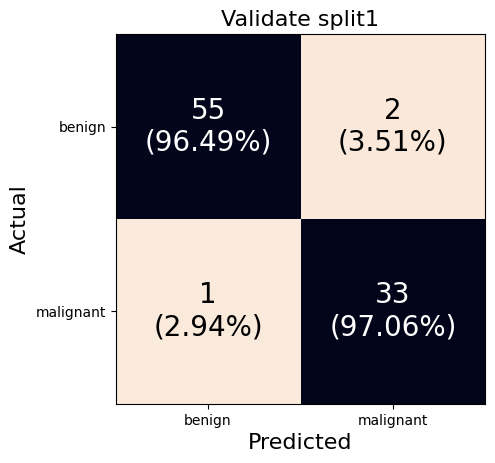

################# test set ##################
Best Threshold=0.400392
FPR: 0.0139
TPR: 1.0000
Confusion Matrix
----------------
[[71  1]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 99.12%
Precision: 97.67%
Sensitivity: 100.00%
Precision: 97.67%
F1: 98.82%


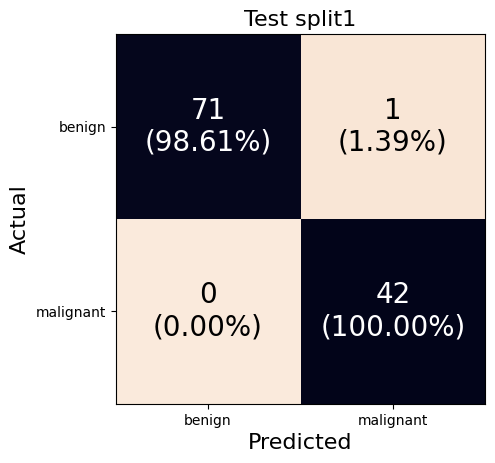

---------------------------------------
AUC validate: 99.17%
AUC test: 99.77%


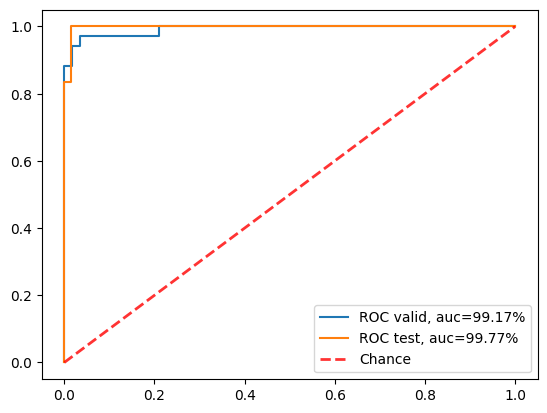

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
8   913102         B         16.85      666.0          0.08641   
36  914862         B         16.74      689.4          0.09883   
79   90291         M         23.29      664.7          0.08682   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
8          0.05192         0.1409                 0.05355      1.0060   
36         0.07721         0.1668                 0.06869      0.8423   
79         0.08390         0.1627                 0.05416      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
8     19.98       0.003535       0.01800      0.01254              0.001219   
36    34.84       0.004123       0.01996      0.01055              0.003237   
79    33.01       0.008312       0.03389      0.01740              0.002871   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
8             0.1142           0.2437       

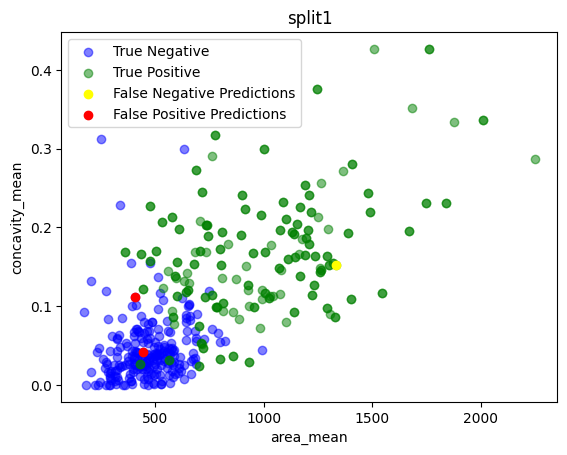

In [15]:
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

In [16]:
# partial_dependence("split1")

In [17]:
# def partial_dependence(split):
#     loaded_model = joblib.load('RF_model/RF_{}.joblib'.format(split))
#     path = "../kitt/DATA_progress3/"
#     train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
#     train_data = pd.read_csv(train_path)
#     # create a PDP for the "mean radius" feature
#     fig, ax = plot_partial_dependence(loaded_model, train_data.iloc[:, 2:18], ["area_mean"])

## param2 split1

############## validate set ################
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


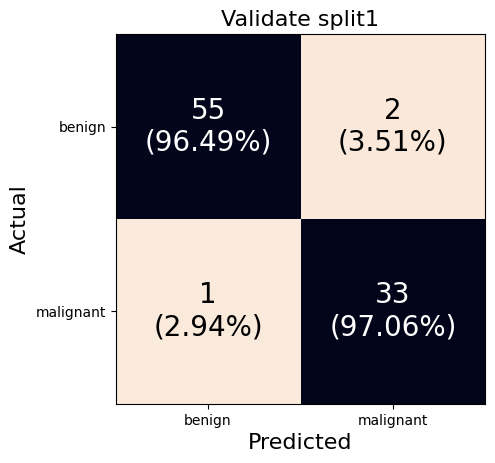

################# test set ##################
Best Threshold=0.400392
FPR: 0.0139
TPR: 1.0000
Confusion Matrix
----------------
[[71  1]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 99.12%
Precision: 97.67%
Sensitivity: 100.00%
Precision: 97.67%
F1: 98.82%


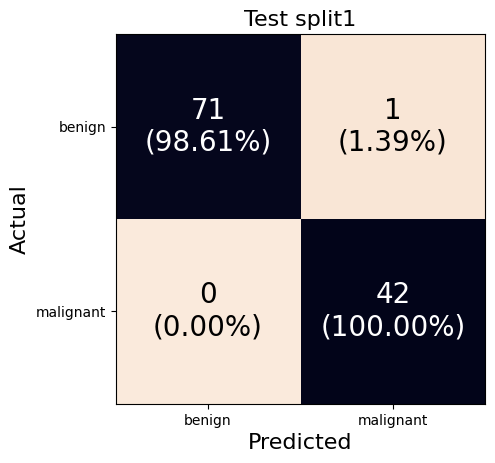

---------------------------------------
AUC validate: 99.17%
AUC test: 99.77%


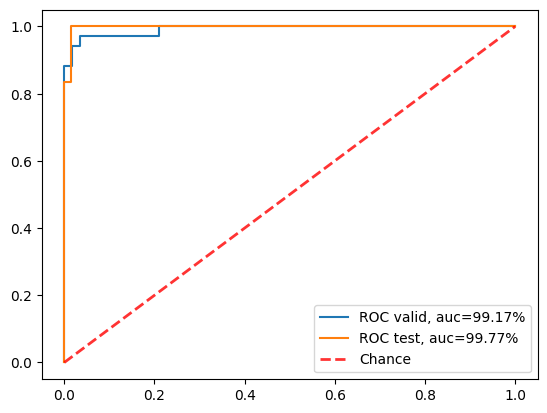

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
8   913102         B         16.85      666.0          0.08641   
36  914862         B         16.74      689.4          0.09883   
79   90291         M         23.29      664.7          0.08682   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
8          0.05192         0.1409                 0.05355      1.0060   
36         0.07721         0.1668                 0.06869      0.8423   
79         0.08390         0.1627                 0.05416      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
8     19.98       0.003535       0.01800      0.01254              0.001219   
36    34.84       0.004123       0.01996      0.01055              0.003237   
79    33.01       0.008312       0.03389      0.01740              0.002871   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
8             0.1142           0.2437       

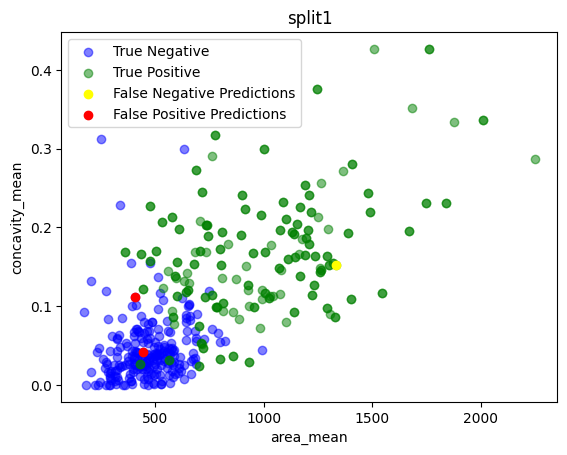

In [18]:
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

## param3 split1

############## validate set ################
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


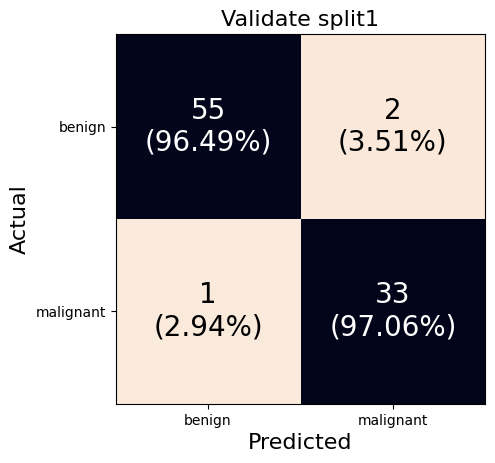

################# test set ##################
Best Threshold=0.400392
FPR: 0.0139
TPR: 1.0000
Confusion Matrix
----------------
[[71  1]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 99.12%
Precision: 97.67%
Sensitivity: 100.00%
Precision: 97.67%
F1: 98.82%


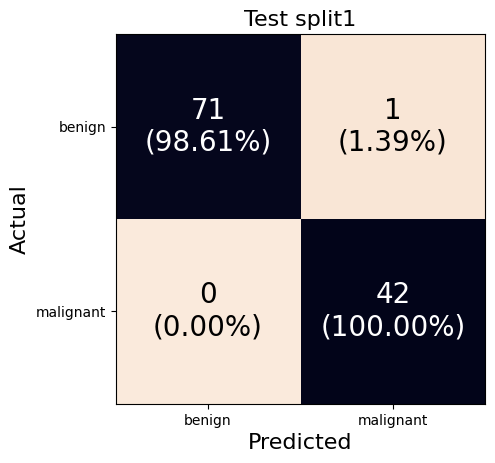

---------------------------------------
AUC validate: 99.17%
AUC test: 99.77%


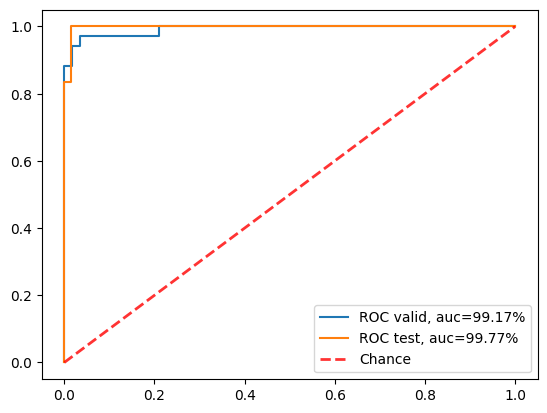

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
8   913102         B         16.85      666.0          0.08641   
36  914862         B         16.74      689.4          0.09883   
79   90291         M         23.29      664.7          0.08682   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
8          0.05192         0.1409                 0.05355      1.0060   
36         0.07721         0.1668                 0.06869      0.8423   
79         0.08390         0.1627                 0.05416      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
8     19.98       0.003535       0.01800      0.01254              0.001219   
36    34.84       0.004123       0.01996      0.01055              0.003237   
79    33.01       0.008312       0.03389      0.01740              0.002871   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
8             0.1142           0.2437       

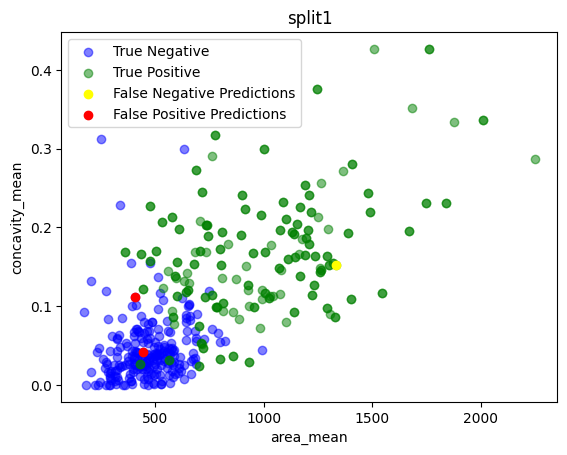

In [19]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

## param4 split1

############## validate set ################
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


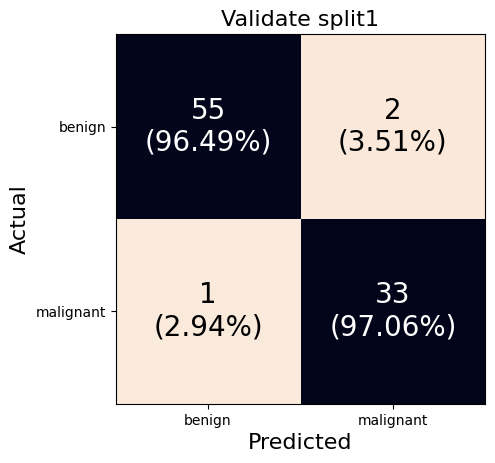

################# test set ##################
Best Threshold=0.400392
FPR: 0.0139
TPR: 1.0000
Confusion Matrix
----------------
[[71  1]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 99.12%
Precision: 97.67%
Sensitivity: 100.00%
Precision: 97.67%
F1: 98.82%


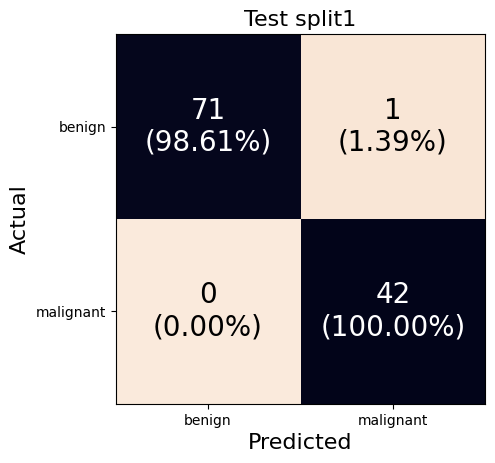

---------------------------------------
AUC validate: 99.17%
AUC test: 99.77%


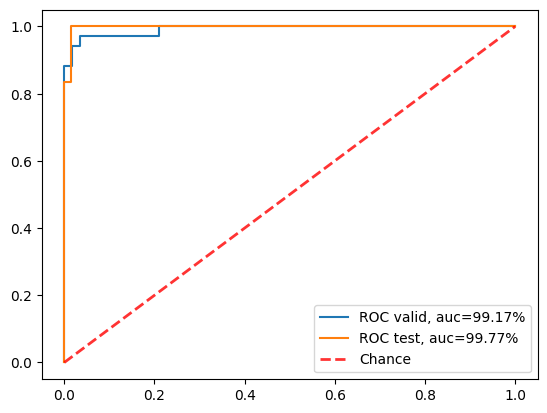

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
8   913102         B         16.85      666.0          0.08641   
36  914862         B         16.74      689.4          0.09883   
79   90291         M         23.29      664.7          0.08682   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
8          0.05192         0.1409                 0.05355      1.0060   
36         0.07721         0.1668                 0.06869      0.8423   
79         0.08390         0.1627                 0.05416      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
8     19.98       0.003535       0.01800      0.01254              0.001219   
36    34.84       0.004123       0.01996      0.01055              0.003237   
79    33.01       0.008312       0.03389      0.01740              0.002871   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
8             0.1142           0.2437       

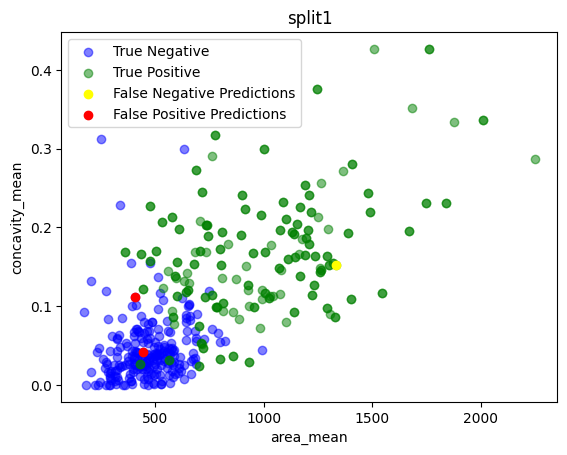

In [20]:
param = 4
param4_split1_cm_val, param4_split1_cm_test, param4_split1_AUC_val, param4_split1_AUC_test = evaluate(param,split)

## param5 split1

############## validate set ################
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


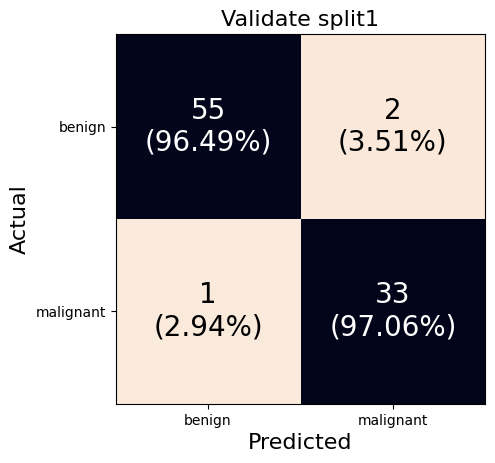

################# test set ##################
Best Threshold=0.400392
FPR: 0.0139
TPR: 1.0000
Confusion Matrix
----------------
[[71  1]
 [ 0 42]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.61%
Accuracy: 99.12%
Precision: 97.67%
Sensitivity: 100.00%
Precision: 97.67%
F1: 98.82%


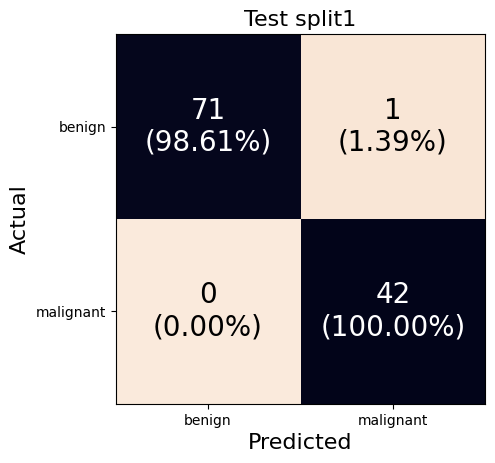

---------------------------------------
AUC validate: 99.17%
AUC test: 99.77%


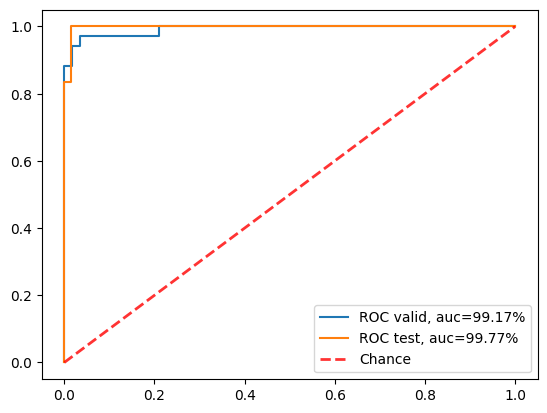

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
8   913102         B         16.85      666.0          0.08641   
36  914862         B         16.74      689.4          0.09883   
79   90291         M         23.29      664.7          0.08682   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
8          0.05192         0.1409                 0.05355      1.0060   
36         0.07721         0.1668                 0.06869      0.8423   
79         0.08390         0.1627                 0.05416      1.6270   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
8     19.98       0.003535       0.01800      0.01254              0.001219   
36    34.84       0.004123       0.01996      0.01055              0.003237   
79    33.01       0.008312       0.03389      0.01740              0.002871   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
8             0.1142           0.2437       

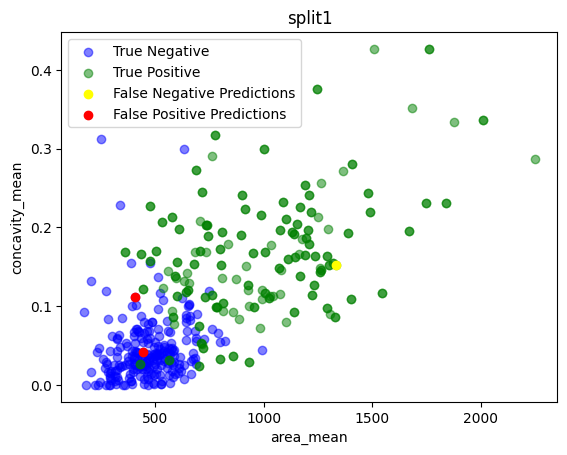

In [21]:
param = 5
param5_split1_cm_val, param5_split1_cm_test, param5_split1_AUC_val, param5_split1_AUC_test = evaluate(param,split)

# Setting Split 2

In [22]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split2

############## validate set ################
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


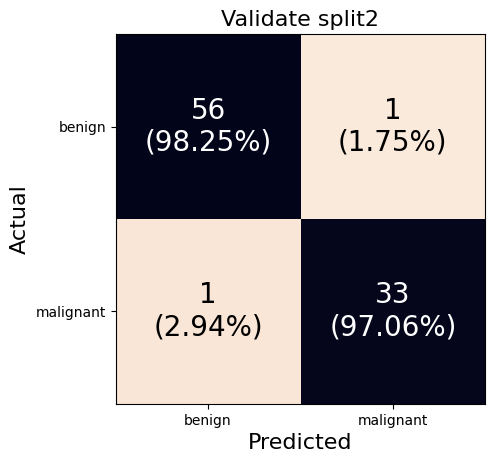

################# test set ##################
Best Threshold=0.487101
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


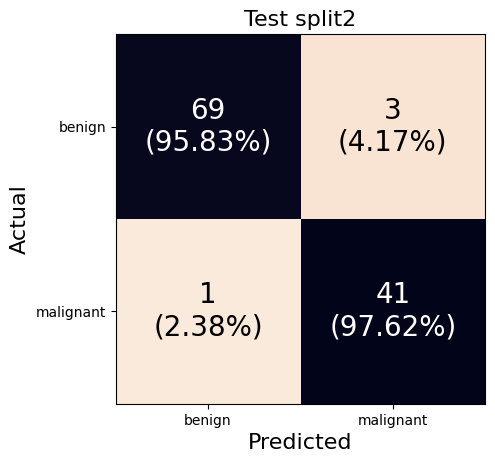

---------------------------------------
AUC validate: 99.17%
AUC test: 99.44%


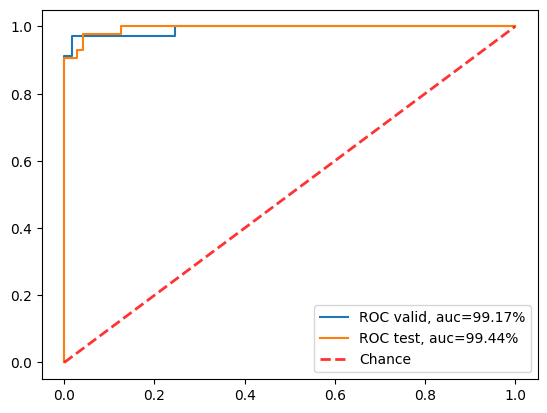

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
11  902976         B         16.16      596.6          0.07026   
57  871641         B         14.71      372.7          0.10060   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.02045         0.1607                 0.05474      0.6218   
57         0.02363         0.1566                 0.06669      1.8050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    23.12       0.003728       0.01988      0.01647              0.001970   
57    19.08       0.014960       0.01453      0.03082              0.004785   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
11           0.08484          0.10910          0.2542                  0.06623  
57           0.12160          0.03938          0.1902                  0.07313  


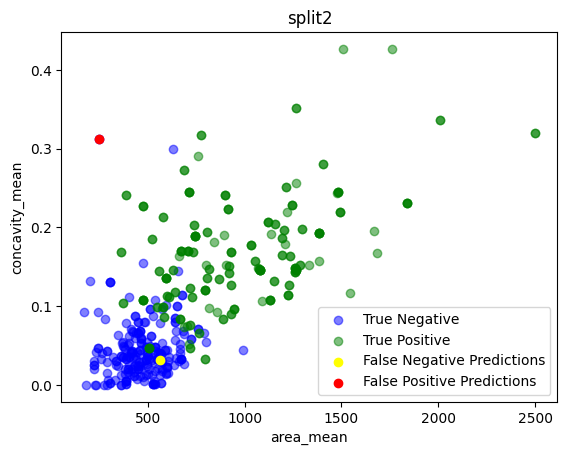

In [23]:
param = 1
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## param2 split2

############## validate set ################
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


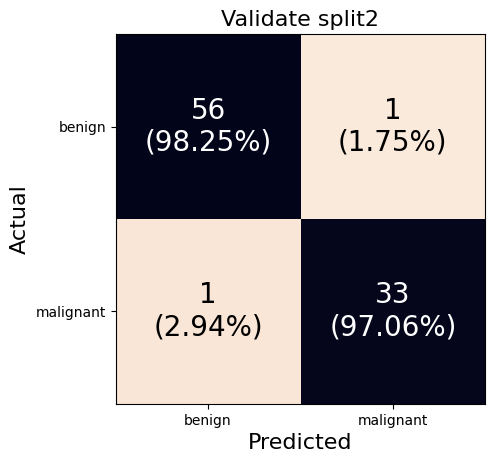

################# test set ##################
Best Threshold=0.487101
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


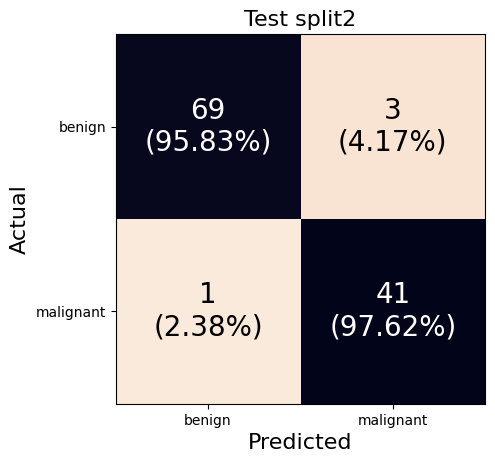

---------------------------------------
AUC validate: 99.17%
AUC test: 99.44%


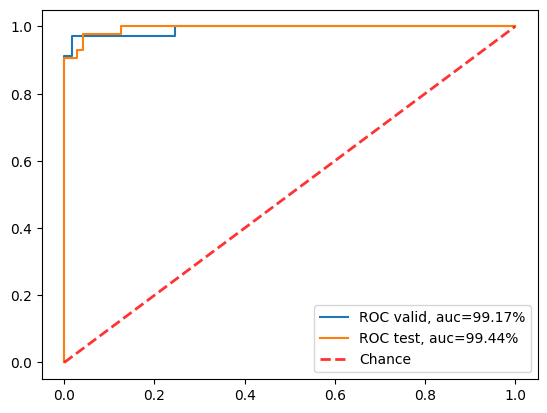

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
11  902976         B         16.16      596.6          0.07026   
57  871641         B         14.71      372.7          0.10060   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.02045         0.1607                 0.05474      0.6218   
57         0.02363         0.1566                 0.06669      1.8050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    23.12       0.003728       0.01988      0.01647              0.001970   
57    19.08       0.014960       0.01453      0.03082              0.004785   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
11           0.08484          0.10910          0.2542                  0.06623  
57           0.12160          0.03938          0.1902                  0.07313  


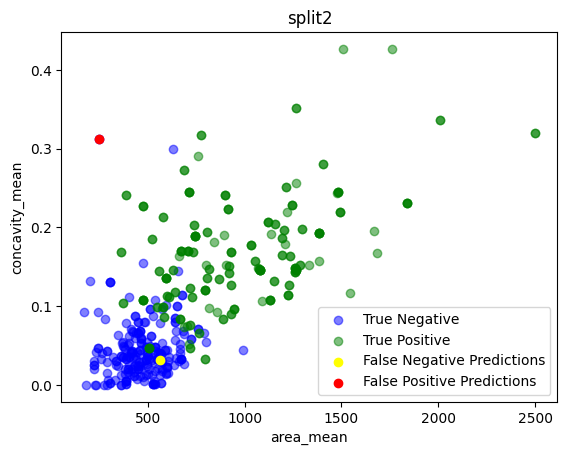

In [24]:
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

## param3 split2

############## validate set ################
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


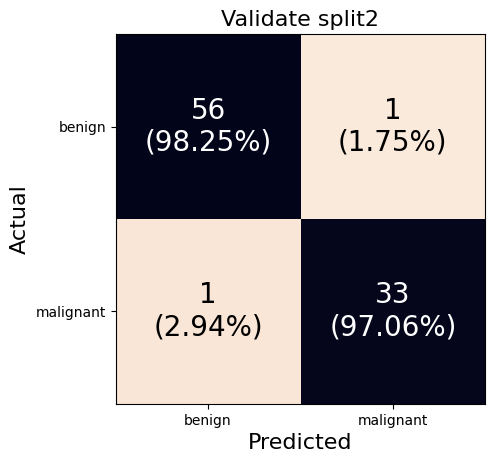

################# test set ##################
Best Threshold=0.487101
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


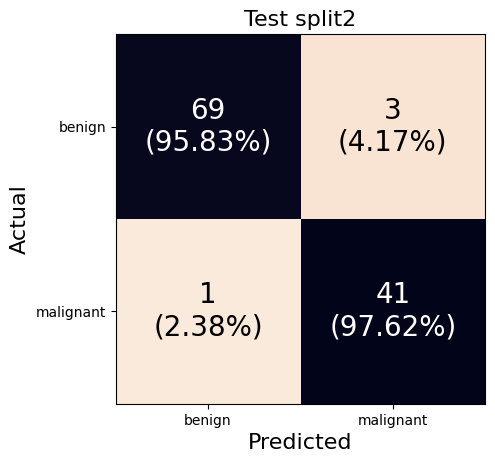

---------------------------------------
AUC validate: 99.17%
AUC test: 99.44%


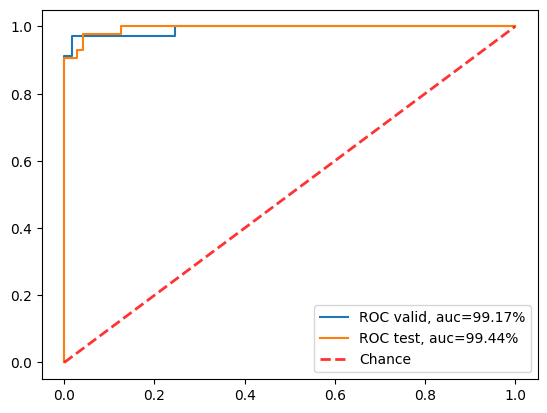

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
11  902976         B         16.16      596.6          0.07026   
57  871641         B         14.71      372.7          0.10060   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.02045         0.1607                 0.05474      0.6218   
57         0.02363         0.1566                 0.06669      1.8050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    23.12       0.003728       0.01988      0.01647              0.001970   
57    19.08       0.014960       0.01453      0.03082              0.004785   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
11           0.08484          0.10910          0.2542                  0.06623  
57           0.12160          0.03938          0.1902                  0.07313  


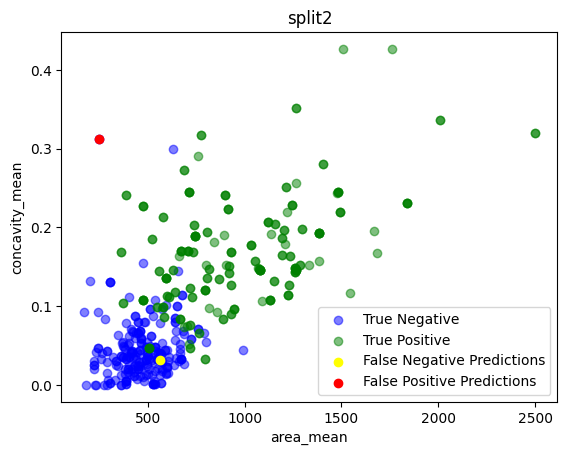

In [25]:
param = 3
param3_split2_cm_val, param3_split2_cm_test, param3_split2_AUC_val, param3_split2_AUC_test = evaluate(param,split)

## param4 split2

############## validate set ################
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


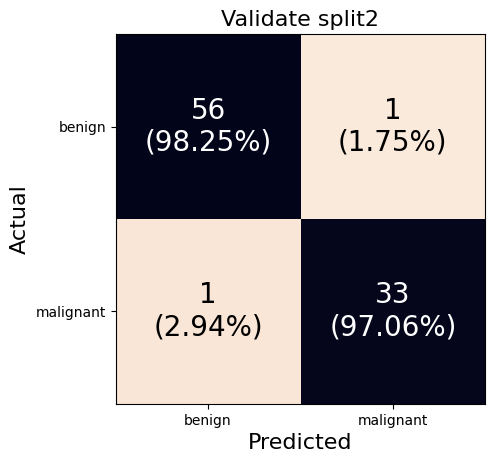

################# test set ##################
Best Threshold=0.487101
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


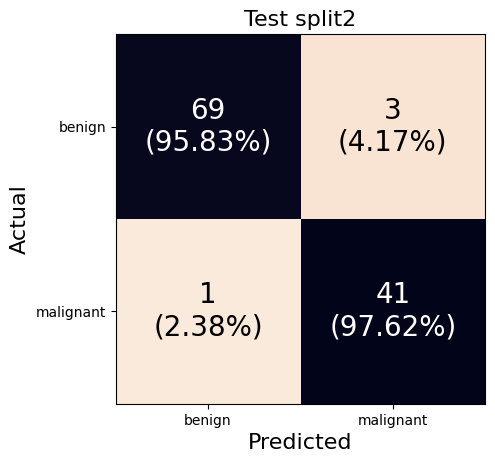

---------------------------------------
AUC validate: 99.17%
AUC test: 99.44%


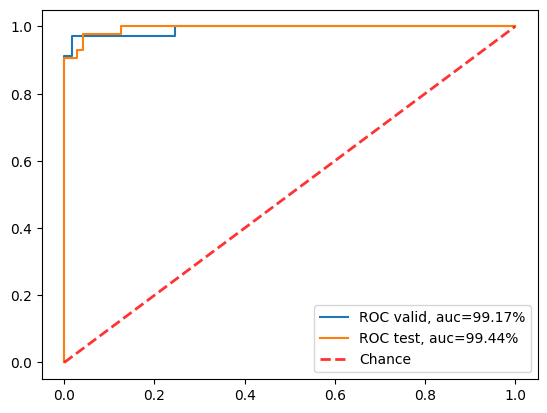

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
11  902976         B         16.16      596.6          0.07026   
57  871641         B         14.71      372.7          0.10060   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.02045         0.1607                 0.05474      0.6218   
57         0.02363         0.1566                 0.06669      1.8050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    23.12       0.003728       0.01988      0.01647              0.001970   
57    19.08       0.014960       0.01453      0.03082              0.004785   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
11           0.08484          0.10910          0.2542                  0.06623  
57           0.12160          0.03938          0.1902                  0.07313  


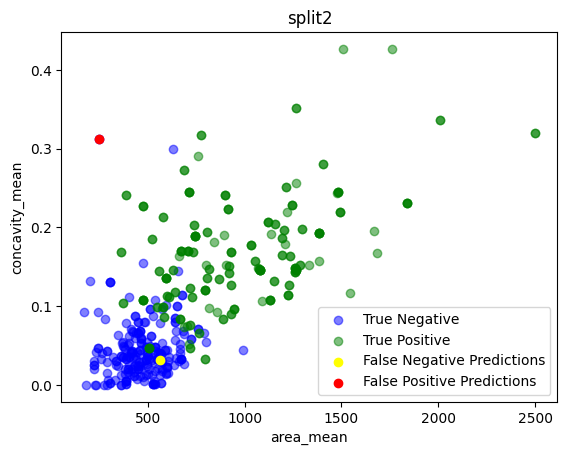

In [26]:
param = 4
param4_split2_cm_val, param4_split2_cm_test, param4_split2_AUC_val, param4_split2_AUC_test = evaluate(param,split)

## param5 split2

############## validate set ################
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


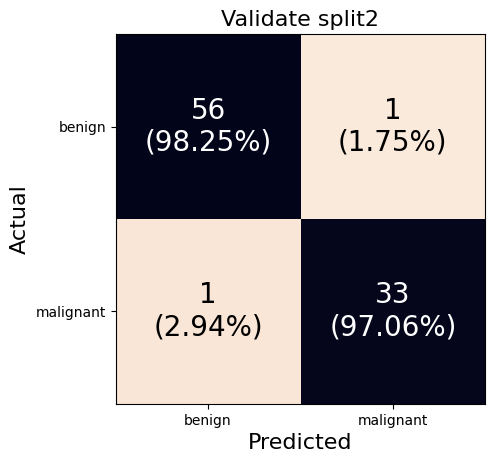

################# test set ##################
Best Threshold=0.487101
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


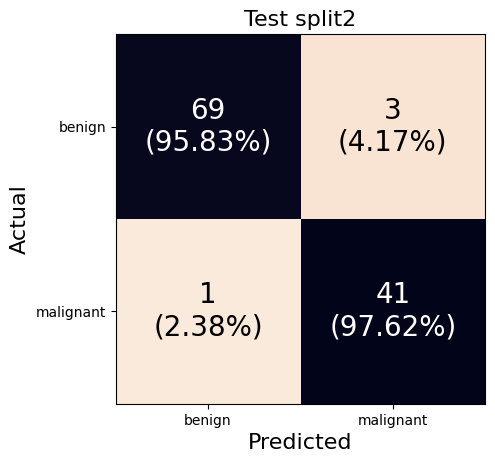

---------------------------------------
AUC validate: 99.17%
AUC test: 99.44%


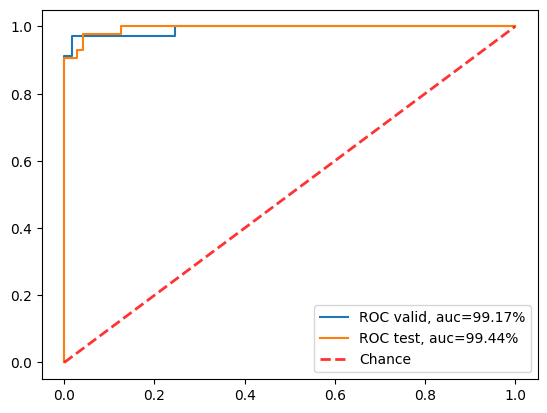

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
11  902976         B         16.16      596.6          0.07026   
57  871641         B         14.71      372.7          0.10060   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
11         0.02045         0.1607                 0.05474      0.6218   
57         0.02363         0.1566                 0.06669      1.8050   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
11    23.12       0.003728       0.01988      0.01647              0.001970   
57    19.08       0.014960       0.01453      0.03082              0.004785   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
11           0.08484          0.10910          0.2542                  0.06623  
57           0.12160          0.03938          0.1902                  0.07313  


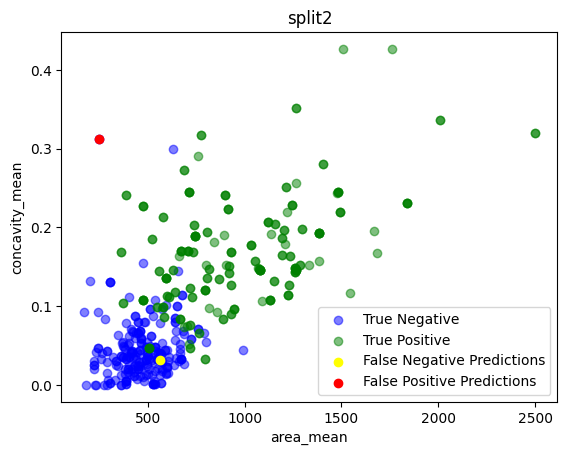

In [27]:
param = 5
param5_split2_cm_val, param5_split2_cm_test, param5_split2_AUC_val, param5_split2_AUC_test = evaluate(param,split)

# Setting Split 3

In [28]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split3

############## validate set ################
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
Confusion Matrix
----------------
[[57  0]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


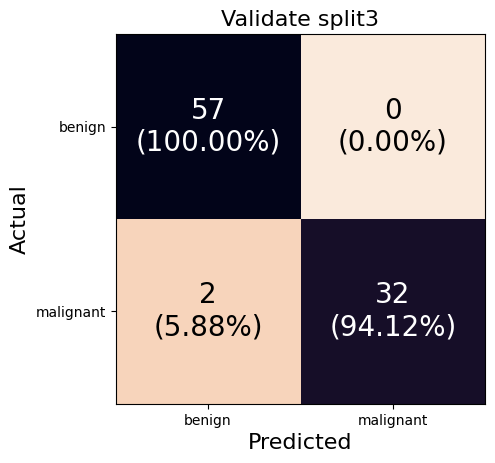

################# test set ##################
Best Threshold=0.444183
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


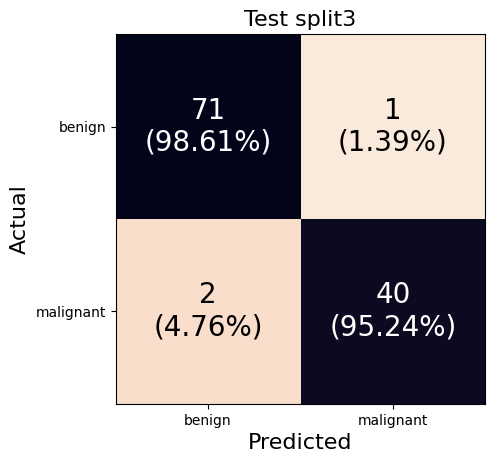

---------------------------------------
AUC validate: 98.61%
AUC test: 99.60%


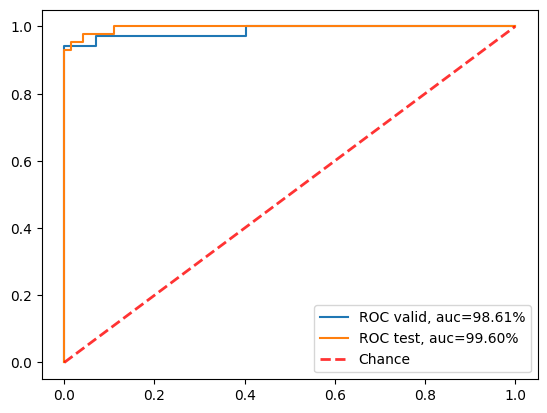

          id diagnosis  texture_mean  area_mean  smoothness_mean  \
81  88330202         M         39.28      920.6          0.09812   
87    889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
81         0.14170         0.1809                 0.05966      0.8561   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
81    49.00       0.004860       0.02602      0.01226              0.002759   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
81            0.1365           0.3241          0.2853                  0.08496  
87            0.1558           0.3889          0.3216                  0.07570  


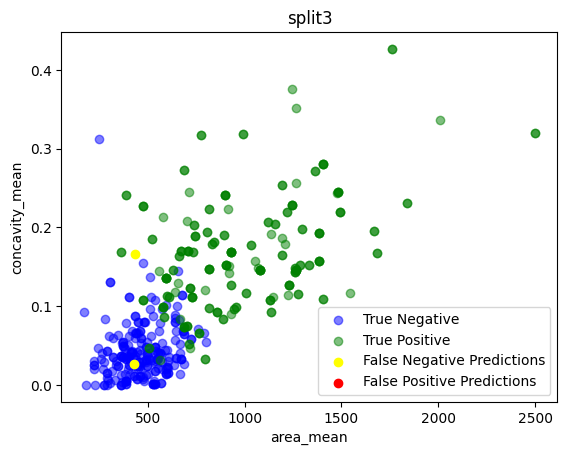

In [29]:
param = 1
param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## param2 split3

############## validate set ################
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
Confusion Matrix
----------------
[[57  0]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


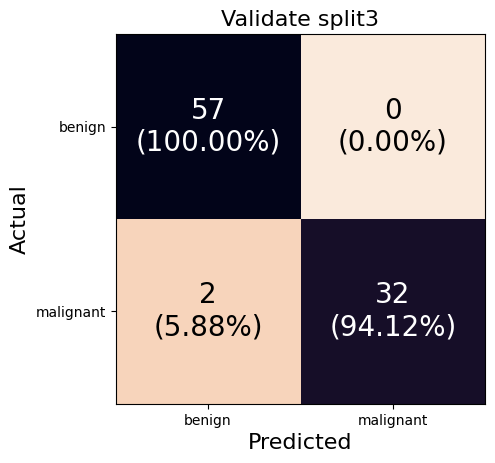

################# test set ##################
Best Threshold=0.444183
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


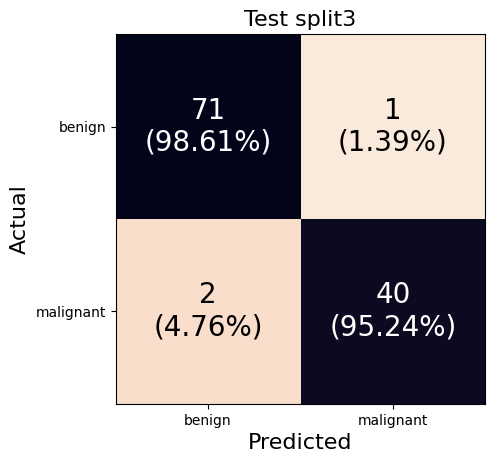

---------------------------------------
AUC validate: 98.61%
AUC test: 99.60%


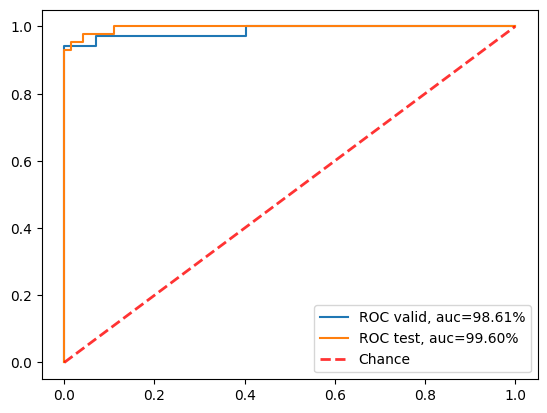

          id diagnosis  texture_mean  area_mean  smoothness_mean  \
81  88330202         M         39.28      920.6          0.09812   
87    889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
81         0.14170         0.1809                 0.05966      0.8561   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
81    49.00       0.004860       0.02602      0.01226              0.002759   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
81            0.1365           0.3241          0.2853                  0.08496  
87            0.1558           0.3889          0.3216                  0.07570  


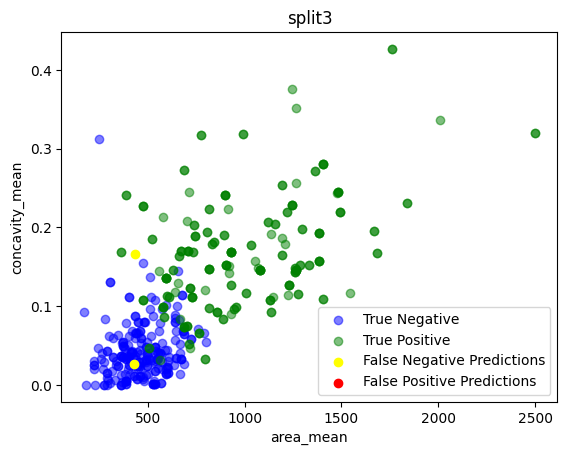

In [30]:
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

## param3 split3

############## validate set ################
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
Confusion Matrix
----------------
[[57  0]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


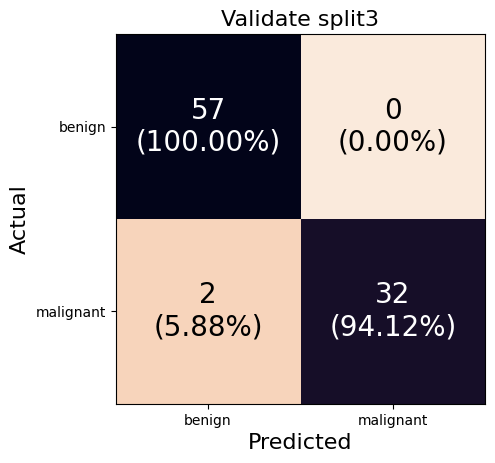

################# test set ##################
Best Threshold=0.444183
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


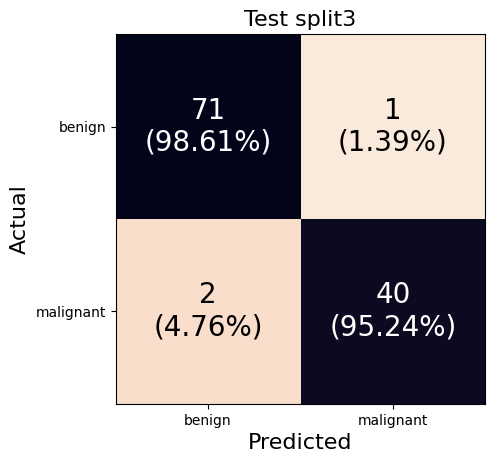

---------------------------------------
AUC validate: 98.61%
AUC test: 99.60%


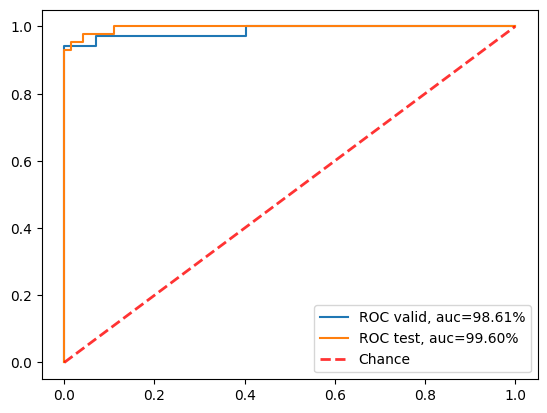

          id diagnosis  texture_mean  area_mean  smoothness_mean  \
81  88330202         M         39.28      920.6          0.09812   
87    889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
81         0.14170         0.1809                 0.05966      0.8561   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
81    49.00       0.004860       0.02602      0.01226              0.002759   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
81            0.1365           0.3241          0.2853                  0.08496  
87            0.1558           0.3889          0.3216                  0.07570  


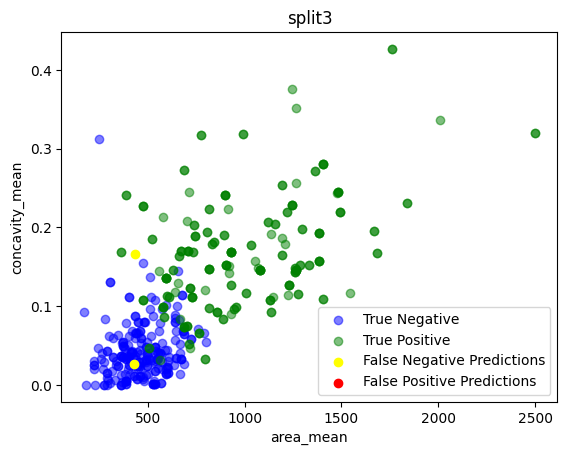

In [31]:
param = 3
param3_split3_cm_val, param3_split3_cm_test, param3_split3_AUC_val, param3_split3_AUC_test = evaluate(param,split)

## param4 split3

############## validate set ################
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
Confusion Matrix
----------------
[[57  0]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


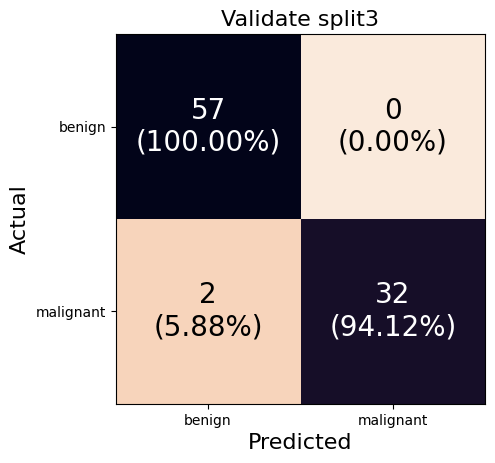

################# test set ##################
Best Threshold=0.444183
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


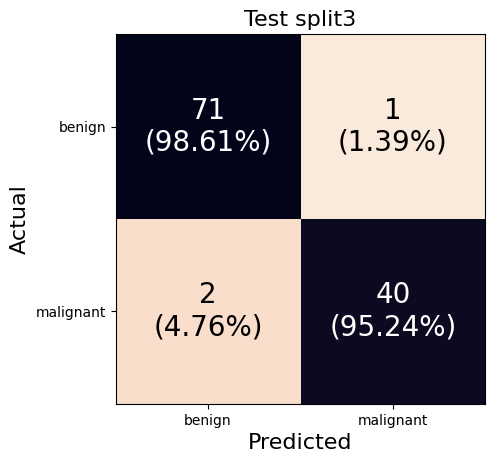

---------------------------------------
AUC validate: 98.61%
AUC test: 99.60%


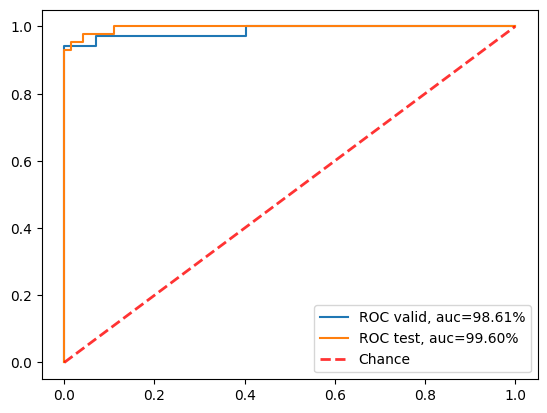

          id diagnosis  texture_mean  area_mean  smoothness_mean  \
81  88330202         M         39.28      920.6          0.09812   
87    889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
81         0.14170         0.1809                 0.05966      0.8561   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
81    49.00       0.004860       0.02602      0.01226              0.002759   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
81            0.1365           0.3241          0.2853                  0.08496  
87            0.1558           0.3889          0.3216                  0.07570  


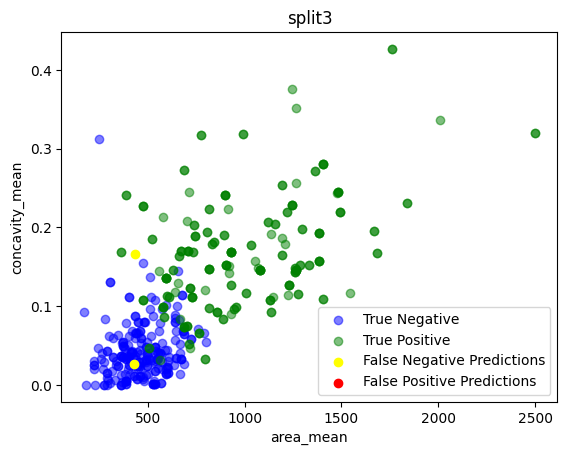

In [32]:
param = 4
param4_split3_cm_val, param4_split3_cm_test, param4_split3_AUC_val, param4_split3_AUC_test = evaluate(param,split)

## param5 split3

############## validate set ################
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
Confusion Matrix
----------------
[[57  0]
 [ 2 32]] 

----------------
split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


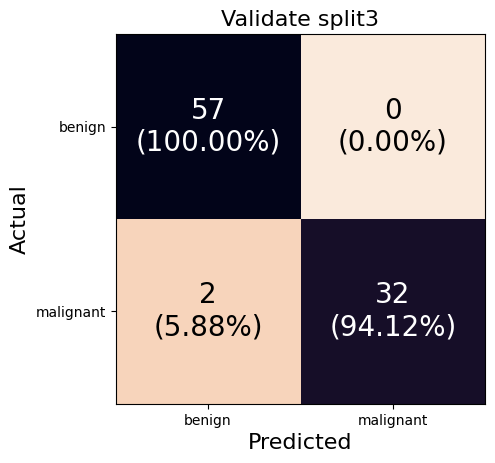

################# test set ##################
Best Threshold=0.444183
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


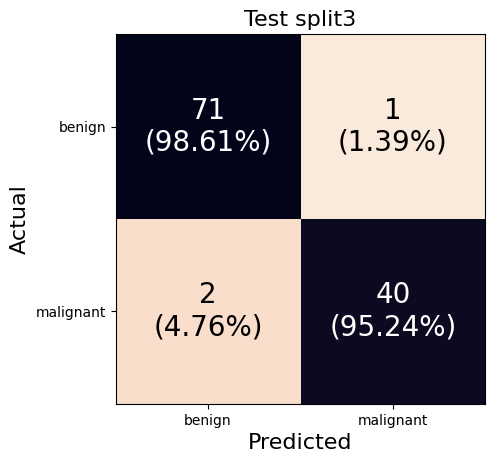

---------------------------------------
AUC validate: 98.61%
AUC test: 99.60%


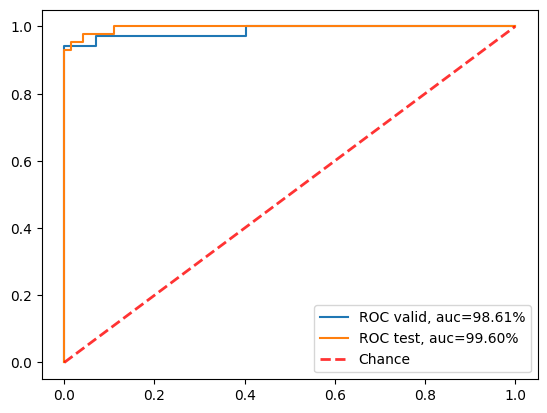

          id diagnosis  texture_mean  area_mean  smoothness_mean  \
81  88330202         M         39.28      920.6          0.09812   
87    889719         M         22.07      928.3          0.09726   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
81         0.14170         0.1809                 0.05966      0.8561   
87         0.09061         0.1867                 0.05580      0.7383   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
81    49.00       0.004860       0.02602      0.01226              0.002759   
87    45.42       0.004493       0.02048      0.01144              0.001575   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
81            0.1365           0.3241          0.2853                  0.08496  
87            0.1558           0.3889          0.3216                  0.07570  


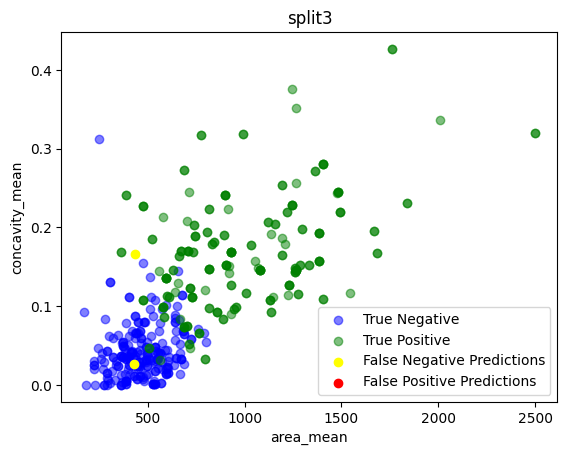

In [33]:
param = 5
param5_split3_cm_val, param5_split3_cm_test, param5_split3_AUC_val, param5_split3_AUC_test = evaluate(param,split)

# Setting Split 4

In [34]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split4

############## validate set ################
Best Threshold=0.695953
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


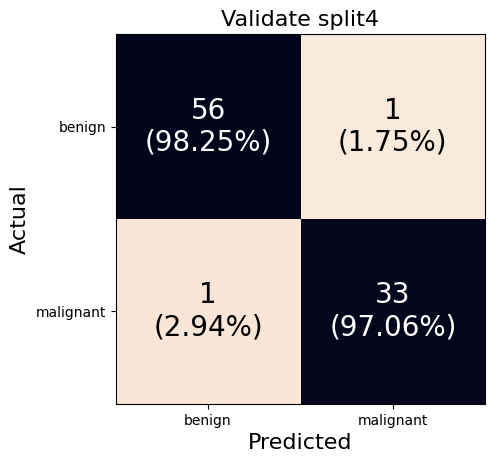

################# test set ##################
Best Threshold=0.580818
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


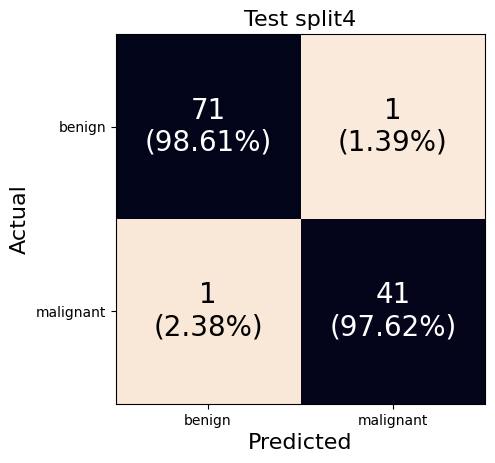

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


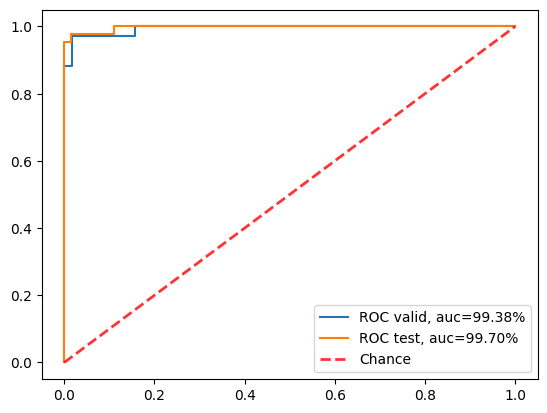

         id diagnosis  texture_mean  area_mean  smoothness_mean  \
37   863270         B         18.54      466.7          0.08477   
70  9012568         B         13.21      711.8          0.07963   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.02643         0.1602                 0.06066      0.8944   
70         0.03393         0.1721                 0.05544      0.4125   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    9.227       0.003457       0.01167      0.01251              0.001356   
70   17.720       0.005012       0.01551      0.01647              0.001767   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1184           0.1937          0.2983                  0.07185  
70            0.1126           0.1362          0.2487                  0.06766  


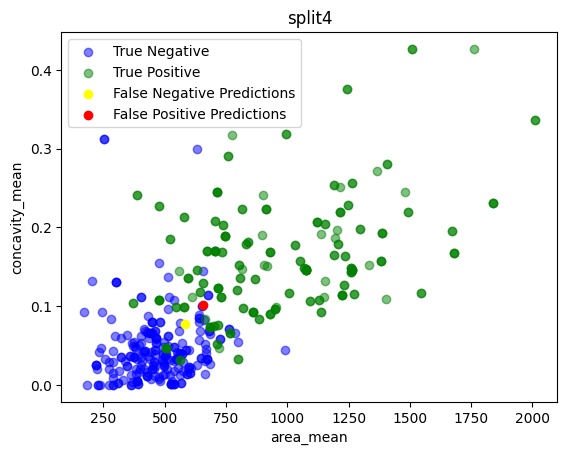

In [35]:
param = 1
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## param2 split4

############## validate set ################
Best Threshold=0.695953
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


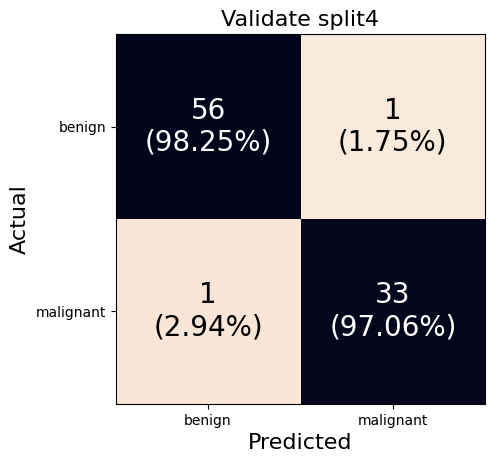

################# test set ##################
Best Threshold=0.580818
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


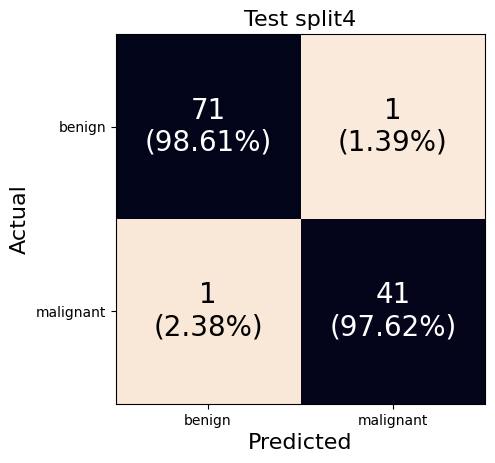

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


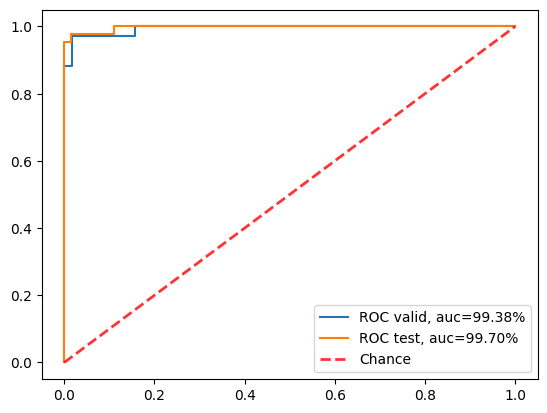

         id diagnosis  texture_mean  area_mean  smoothness_mean  \
37   863270         B         18.54      466.7          0.08477   
70  9012568         B         13.21      711.8          0.07963   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.02643         0.1602                 0.06066      0.8944   
70         0.03393         0.1721                 0.05544      0.4125   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    9.227       0.003457       0.01167      0.01251              0.001356   
70   17.720       0.005012       0.01551      0.01647              0.001767   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1184           0.1937          0.2983                  0.07185  
70            0.1126           0.1362          0.2487                  0.06766  


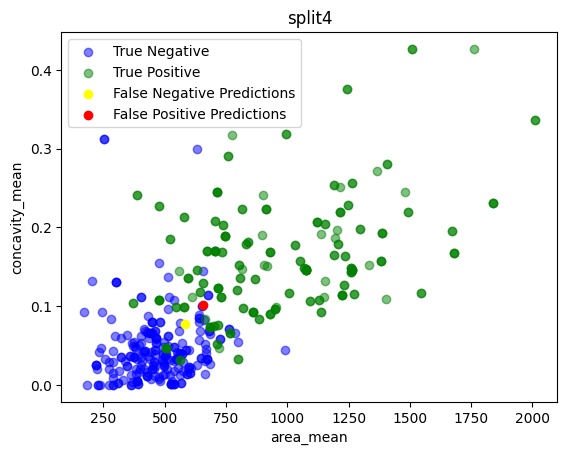

In [36]:
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

## param3 split4

############## validate set ################
Best Threshold=0.695953
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


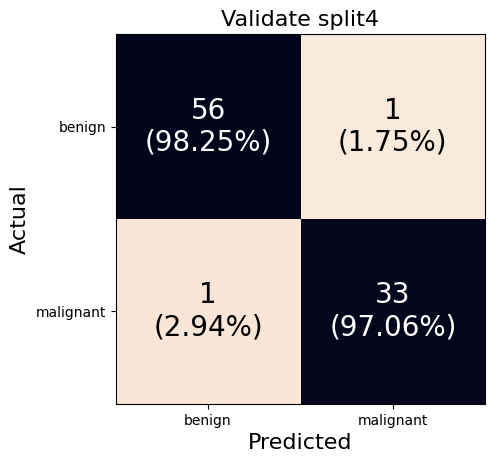

################# test set ##################
Best Threshold=0.580818
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


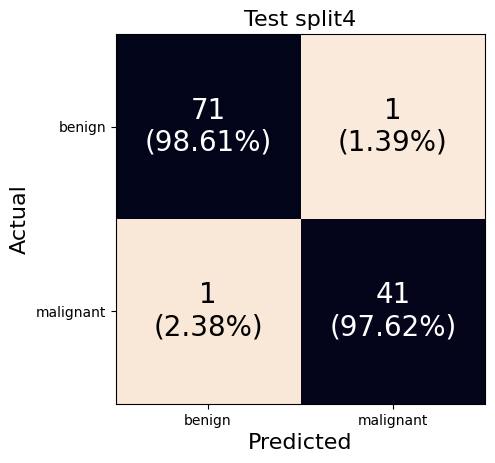

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


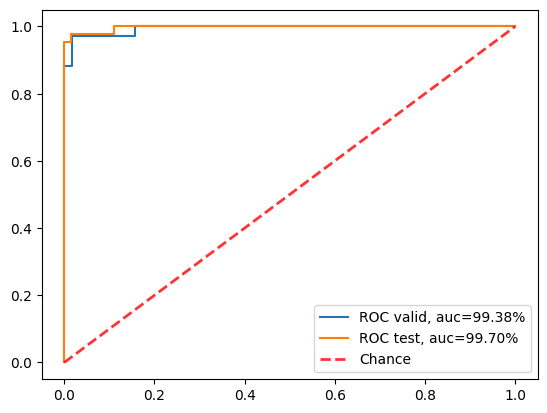

         id diagnosis  texture_mean  area_mean  smoothness_mean  \
37   863270         B         18.54      466.7          0.08477   
70  9012568         B         13.21      711.8          0.07963   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.02643         0.1602                 0.06066      0.8944   
70         0.03393         0.1721                 0.05544      0.4125   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    9.227       0.003457       0.01167      0.01251              0.001356   
70   17.720       0.005012       0.01551      0.01647              0.001767   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1184           0.1937          0.2983                  0.07185  
70            0.1126           0.1362          0.2487                  0.06766  


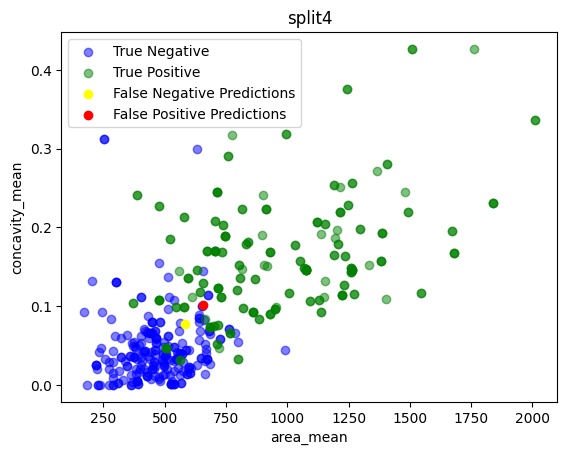

In [37]:
param = 3
param3_split4_cm_val, param3_split4_cm_test, param3_split4_AUC_val, param3_split4_AUC_test = evaluate(param,split)

## param4 split4

############## validate set ################
Best Threshold=0.695953
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


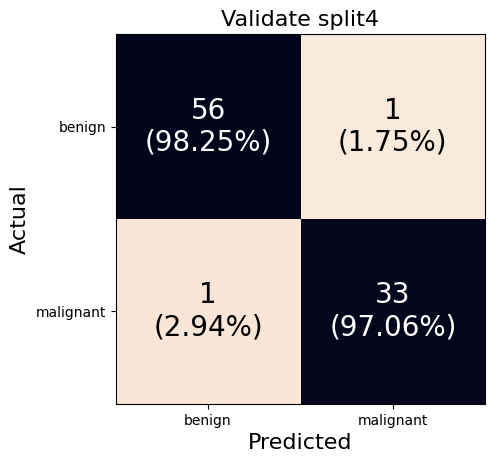

################# test set ##################
Best Threshold=0.580818
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


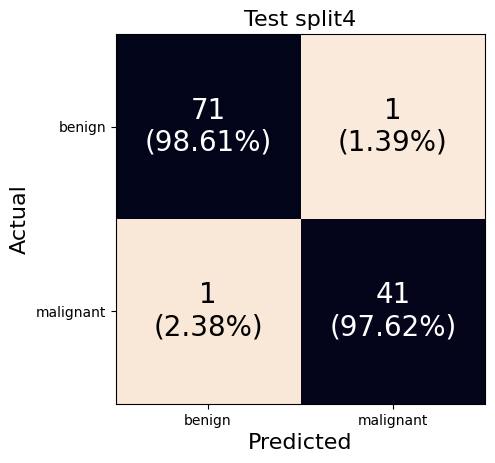

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


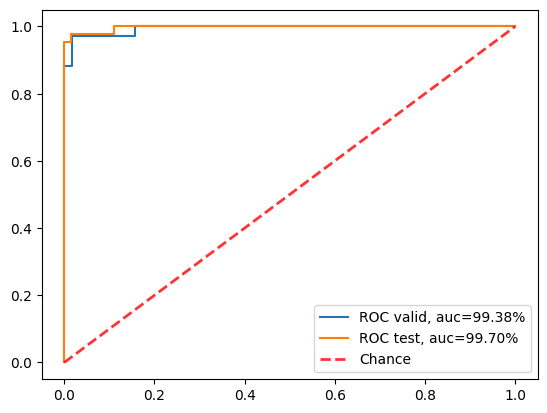

         id diagnosis  texture_mean  area_mean  smoothness_mean  \
37   863270         B         18.54      466.7          0.08477   
70  9012568         B         13.21      711.8          0.07963   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.02643         0.1602                 0.06066      0.8944   
70         0.03393         0.1721                 0.05544      0.4125   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    9.227       0.003457       0.01167      0.01251              0.001356   
70   17.720       0.005012       0.01551      0.01647              0.001767   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1184           0.1937          0.2983                  0.07185  
70            0.1126           0.1362          0.2487                  0.06766  


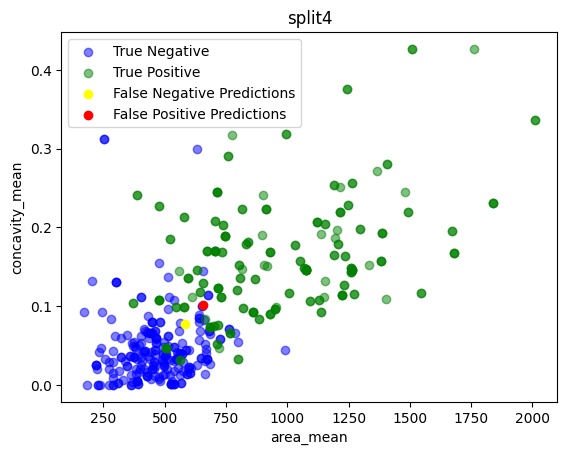

In [38]:
param = 4
param4_split4_cm_val, param4_split4_cm_test, param4_split4_AUC_val, param4_split4_AUC_test = evaluate(param,split)

## param5 split4

############## validate set ################
Best Threshold=0.695953
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


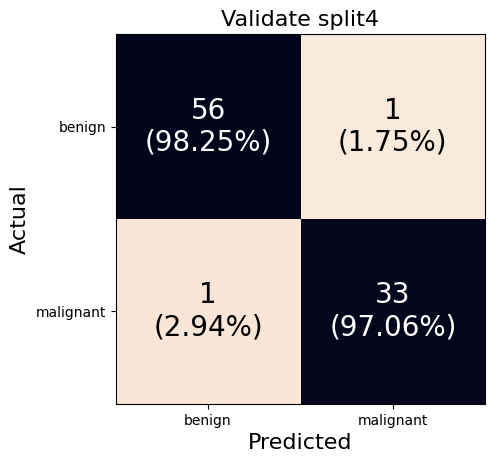

################# test set ##################
Best Threshold=0.580818
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


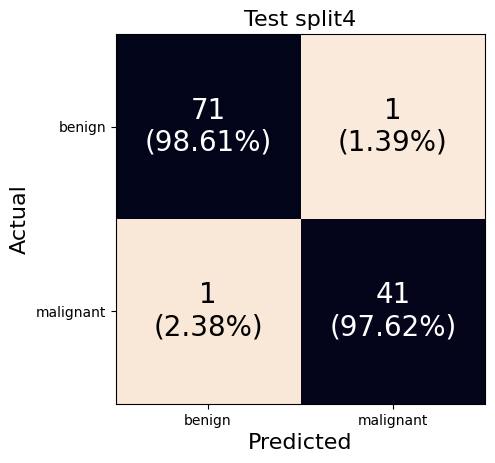

---------------------------------------
AUC validate: 99.38%
AUC test: 99.70%


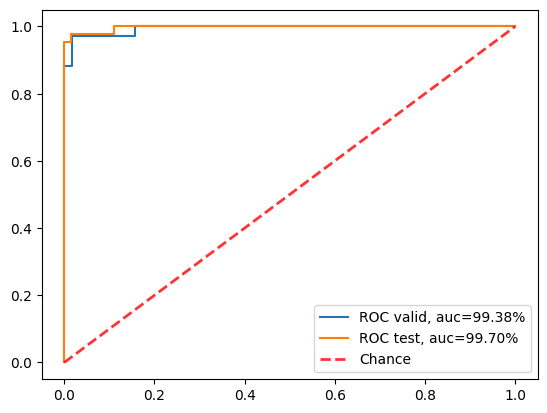

         id diagnosis  texture_mean  area_mean  smoothness_mean  \
37   863270         B         18.54      466.7          0.08477   
70  9012568         B         13.21      711.8          0.07963   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
37         0.02643         0.1602                 0.06066      0.8944   
70         0.03393         0.1721                 0.05544      0.4125   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
37    9.227       0.003457       0.01167      0.01251              0.001356   
70   17.720       0.005012       0.01551      0.01647              0.001767   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
37            0.1184           0.1937          0.2983                  0.07185  
70            0.1126           0.1362          0.2487                  0.06766  


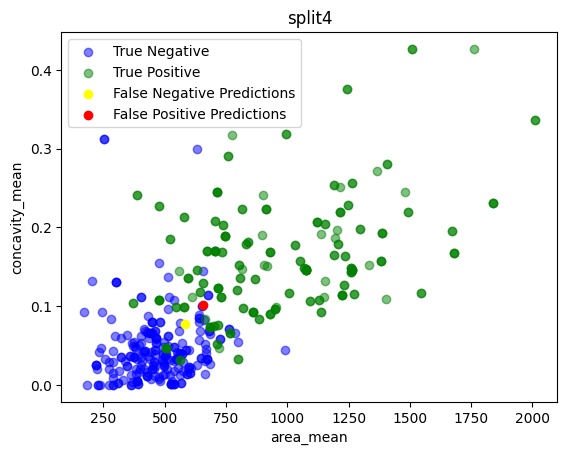

In [39]:
param = 5
param5_split4_cm_val, param5_split4_cm_test, param5_split4_AUC_val, param5_split4_AUC_test = evaluate(param,split)

# Setting Split 5

In [40]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## param1 split5

############## validate set ################
Best Threshold=0.540760
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


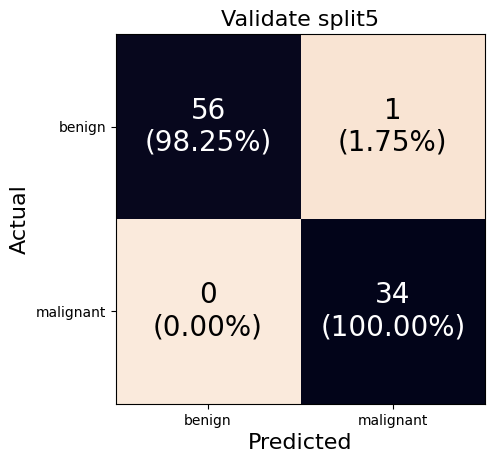

################# test set ##################
Best Threshold=0.426243
FPR: 0.0417
TPR: 1.0000
Confusion Matrix
----------------
[[69  3]
 [ 0 42]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 97.37%
Precision: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1: 96.55%


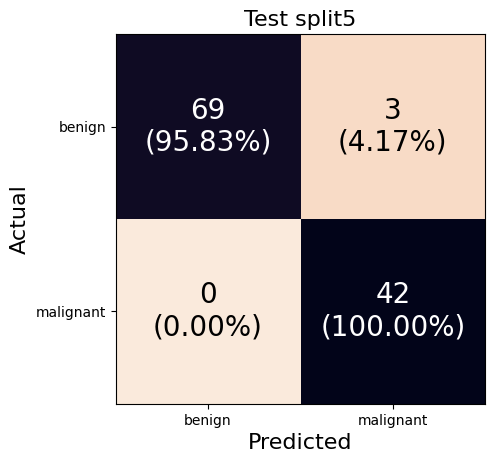

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


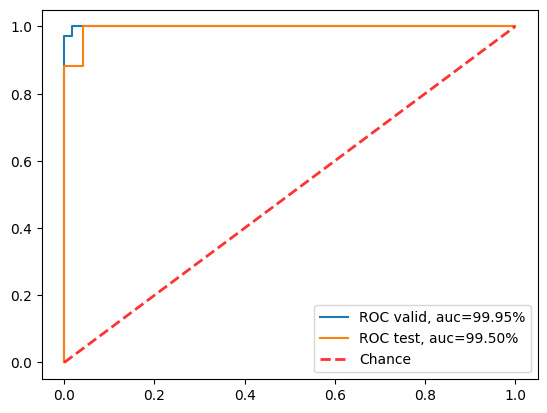

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
44  914101         B         12.83      477.3          0.07372   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
44        0.007173         0.1613                 0.06013       1.486   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
44     24.6        0.01039      0.006416      0.02869              0.004821   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
44           0.09439          0.01674           0.228                  0.07028  


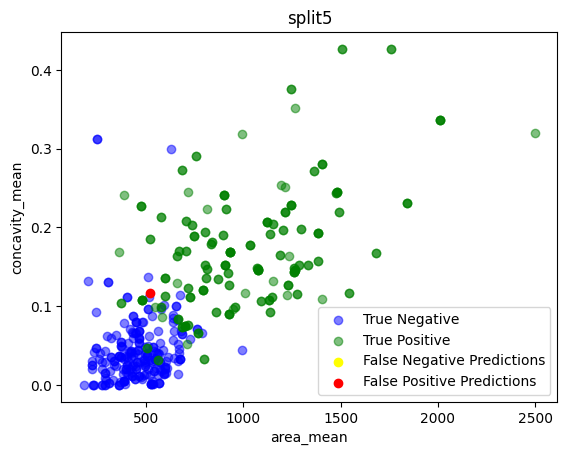

In [41]:
param = 1
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

## param2 split5

############## validate set ################
Best Threshold=0.540760
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


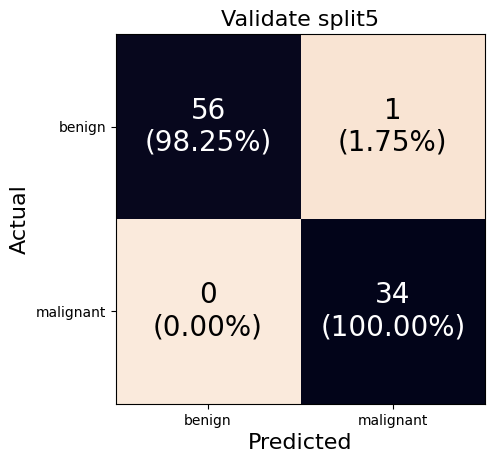

################# test set ##################
Best Threshold=0.426243
FPR: 0.0417
TPR: 1.0000
Confusion Matrix
----------------
[[69  3]
 [ 0 42]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 97.37%
Precision: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1: 96.55%


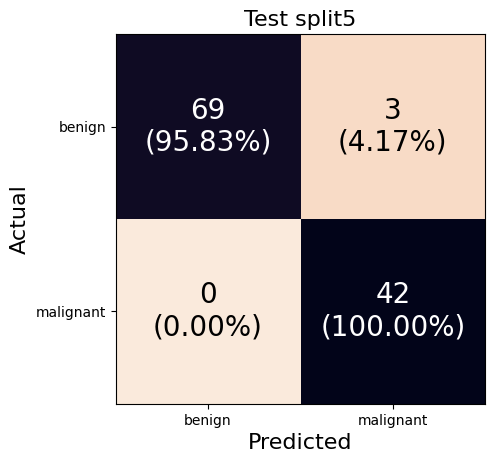

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


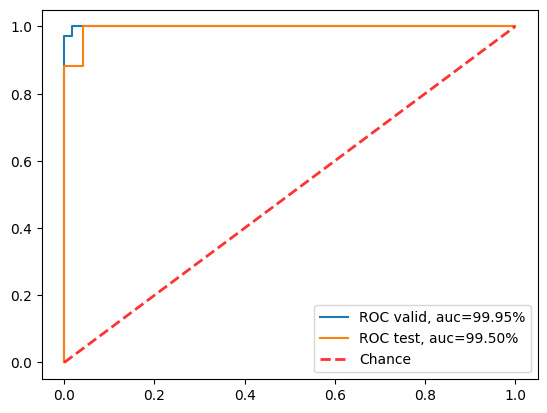

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
44  914101         B         12.83      477.3          0.07372   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
44        0.007173         0.1613                 0.06013       1.486   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
44     24.6        0.01039      0.006416      0.02869              0.004821   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
44           0.09439          0.01674           0.228                  0.07028  


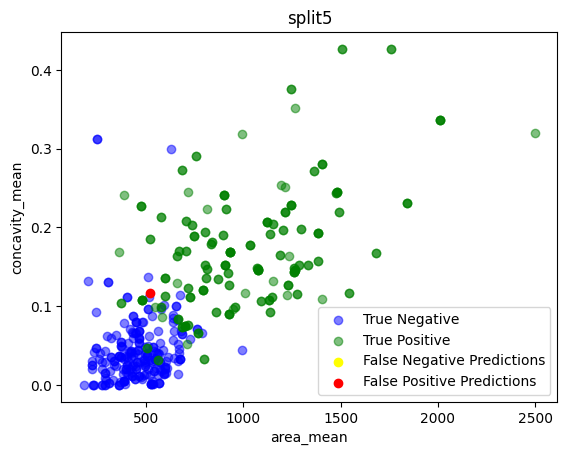

In [42]:
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

## param3 split5

############## validate set ################
Best Threshold=0.540760
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


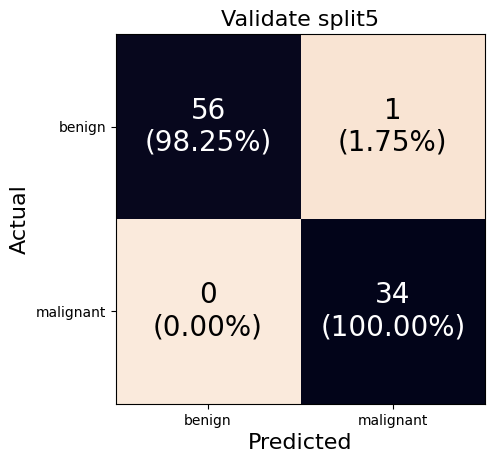

################# test set ##################
Best Threshold=0.426243
FPR: 0.0417
TPR: 1.0000
Confusion Matrix
----------------
[[69  3]
 [ 0 42]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 97.37%
Precision: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1: 96.55%


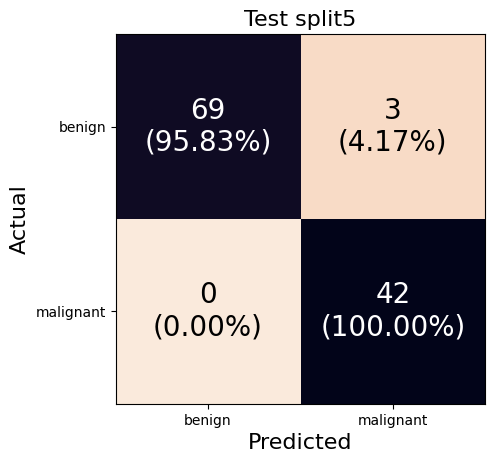

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


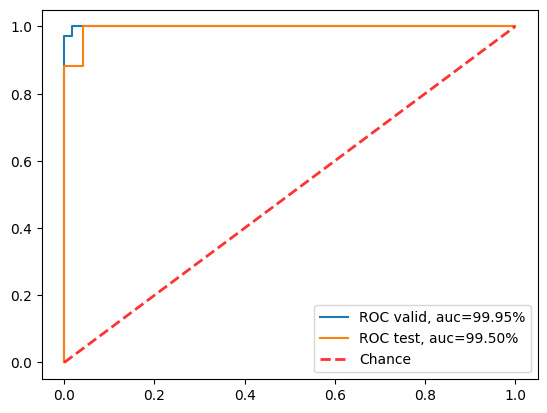

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
44  914101         B         12.83      477.3          0.07372   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
44        0.007173         0.1613                 0.06013       1.486   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
44     24.6        0.01039      0.006416      0.02869              0.004821   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
44           0.09439          0.01674           0.228                  0.07028  


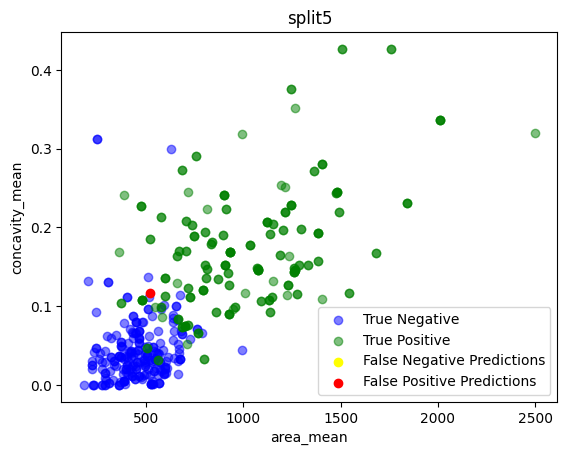

In [43]:
param = 3
param3_split5_cm_val, param3_split5_cm_test, param3_split5_AUC_val, param3_split5_AUC_test = evaluate(param,split)

## param4 split5

############## validate set ################
Best Threshold=0.540760
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


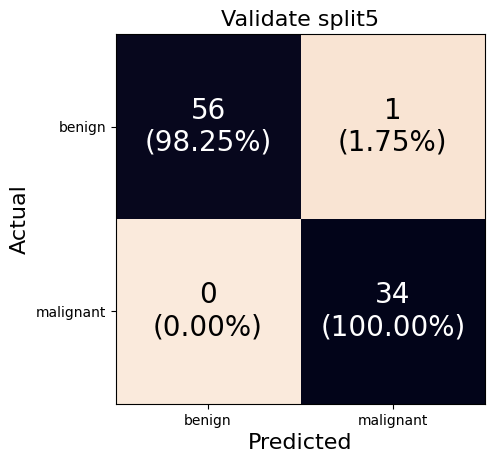

################# test set ##################
Best Threshold=0.426243
FPR: 0.0417
TPR: 1.0000
Confusion Matrix
----------------
[[69  3]
 [ 0 42]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 97.37%
Precision: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1: 96.55%


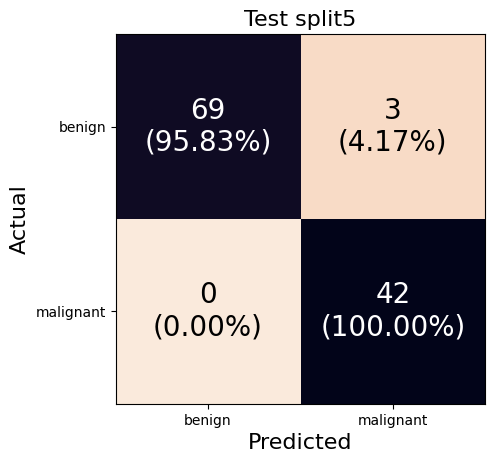

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


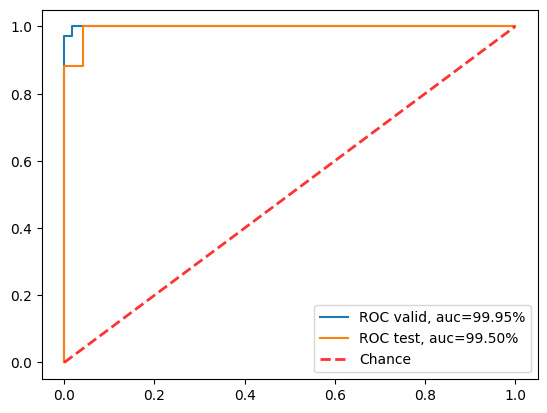

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
44  914101         B         12.83      477.3          0.07372   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
44        0.007173         0.1613                 0.06013       1.486   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
44     24.6        0.01039      0.006416      0.02869              0.004821   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
44           0.09439          0.01674           0.228                  0.07028  


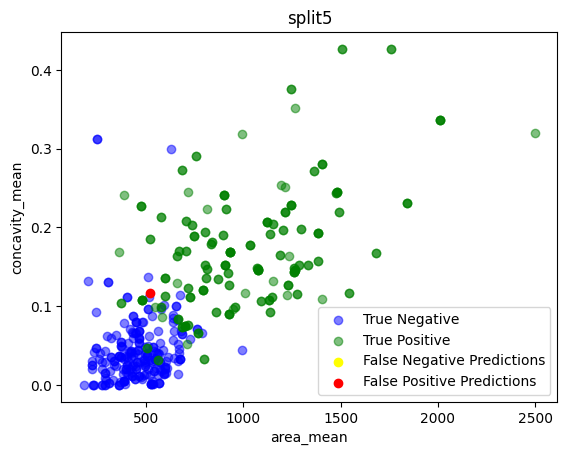

In [44]:
param = 4
param4_split5_cm_val, param4_split5_cm_test, param4_split5_AUC_val, param4_split5_AUC_test = evaluate(param,split)

## param5 split5

############## validate set ################
Best Threshold=0.540760
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


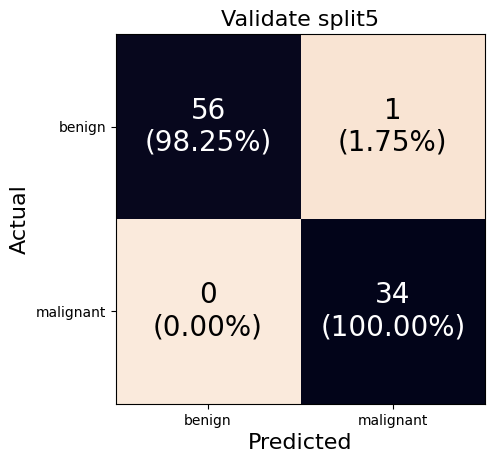

################# test set ##################
Best Threshold=0.426243
FPR: 0.0417
TPR: 1.0000
Confusion Matrix
----------------
[[69  3]
 [ 0 42]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 95.83%
Accuracy: 97.37%
Precision: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1: 96.55%


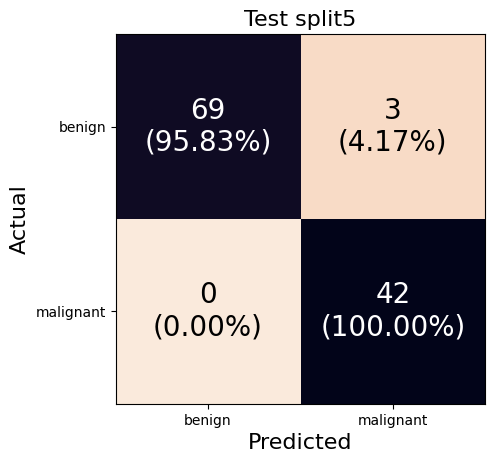

---------------------------------------
AUC validate: 99.95%
AUC test: 99.50%


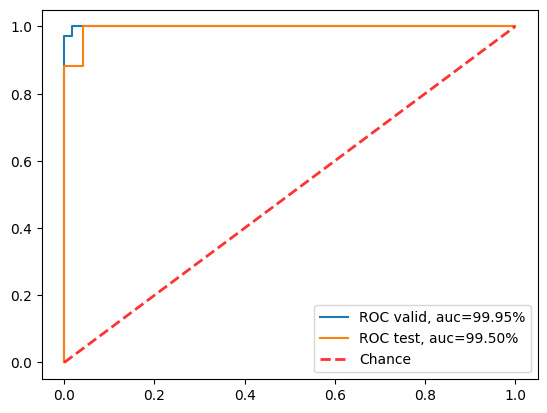

        id diagnosis  texture_mean  area_mean  smoothness_mean  \
44  914101         B         12.83      477.3          0.07372   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
44        0.007173         0.1613                 0.06013       1.486   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
44     24.6        0.01039      0.006416      0.02869              0.004821   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
44           0.09439          0.01674           0.228                  0.07028  


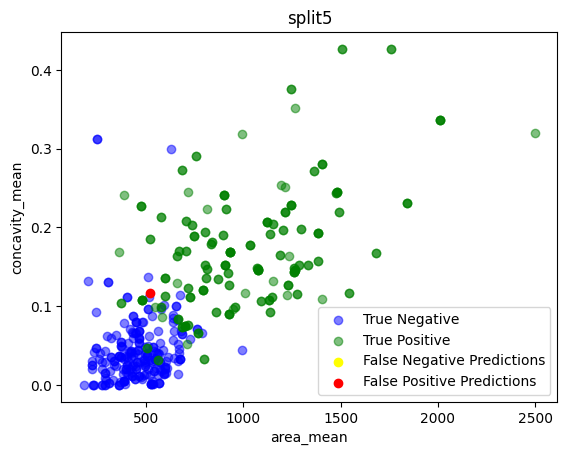

In [45]:
param = 5
param5_split5_cm_val, param5_split5_cm_test, param5_split5_AUC_val, param5_split5_AUC_test = evaluate(param,split)

# overall

In [46]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [47]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

## overall param1

param1
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 0.78%
precision: 97.11 ± 2.02%
f1_score: 97.06 ± 1.03%


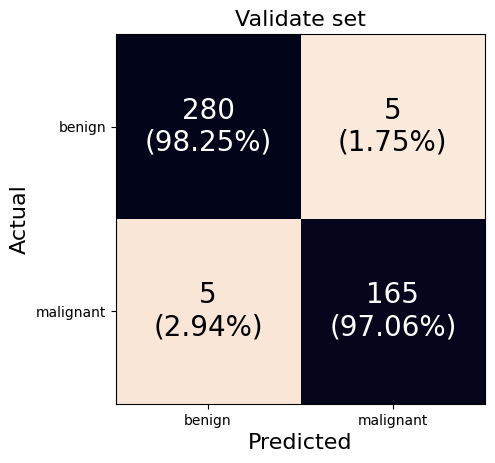

AUC1: 9925.70 ± 48.21%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

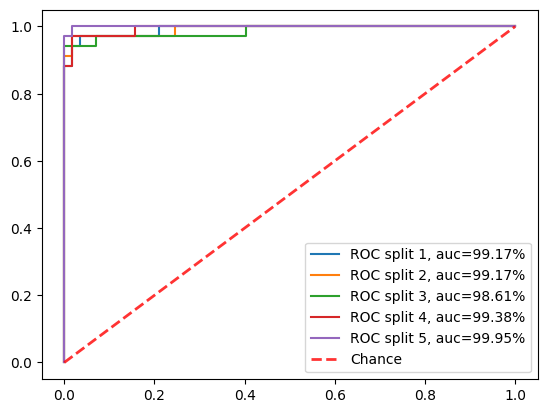

In [48]:
print("param1")
plot(param1_split1_cm_val , param1_split2_cm_val , param1_split3_cm_val , param1_split4_cm_val , param1_split5_cm_val)
Mean_SD("AUC1",param1_split1_AUC_val*100, param1_split2_AUC_val*100, param1_split3_AUC_val*100, param1_split4_AUC_val*100, param1_split5_AUC_val*100)
ROC_split(1)

## overall param2

param2
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 0.78%
precision: 97.11 ± 2.02%
f1_score: 97.06 ± 1.03%


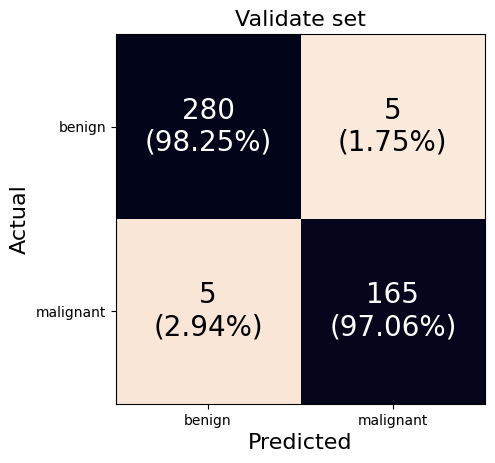

AUC2: 9925.70 ± 48.21%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

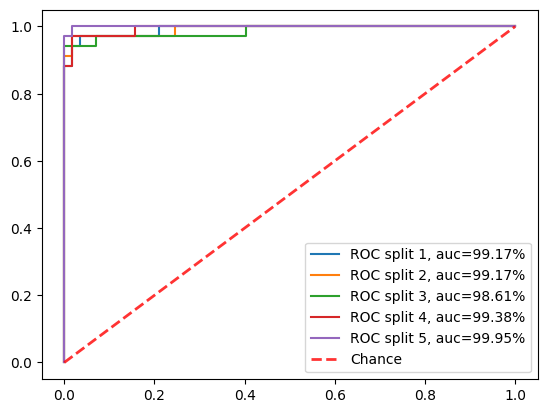

In [49]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC2",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)
ROC_split(2)

## overall param3

param3
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 0.78%
precision: 97.11 ± 2.02%
f1_score: 97.06 ± 1.03%


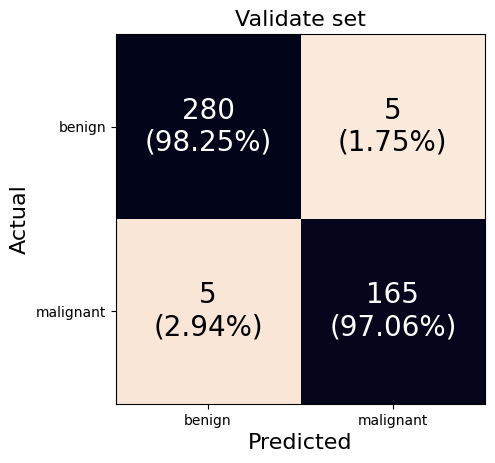

AUC3: 9925.70 ± 48.21%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

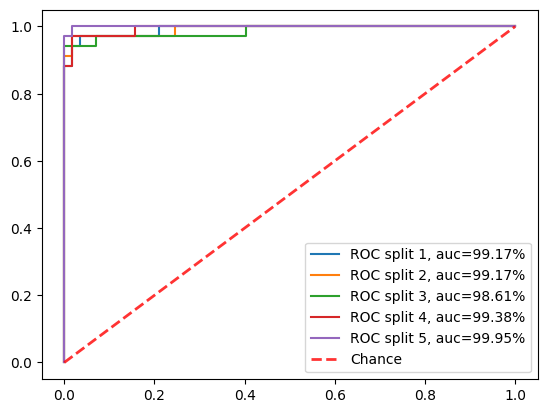

In [50]:
print("param3")
plot(param3_split1_cm_val , param3_split2_cm_val , param3_split3_cm_val , param3_split4_cm_val , param3_split5_cm_val)
Mean_SD("AUC3",param3_split1_AUC_val*100, param3_split2_AUC_val*100, param3_split3_AUC_val*100, param3_split4_AUC_val*100, param3_split5_AUC_val*100)
ROC_split(3)

## overall param4

param4
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 0.78%
precision: 97.11 ± 2.02%
f1_score: 97.06 ± 1.03%


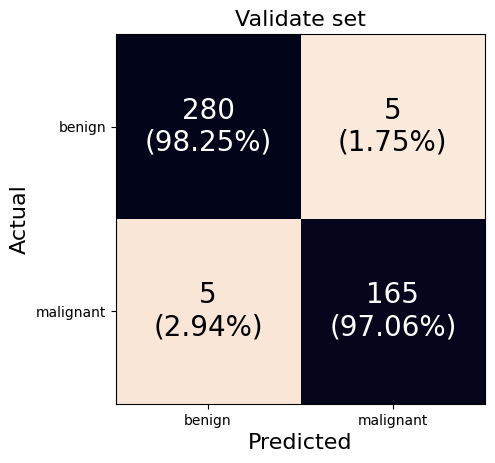

AUC4: 9925.70 ± 48.21%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

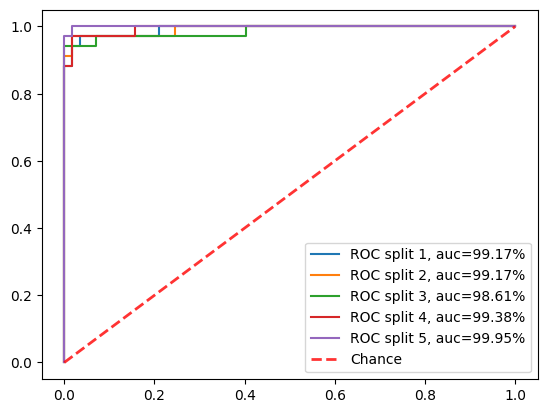

In [51]:
print("param4")
plot(param4_split1_cm_val , param4_split2_cm_val , param4_split3_cm_val , param4_split4_cm_val , param4_split5_cm_val)
Mean_SD("AUC4",param4_split1_AUC_val*100, param4_split2_AUC_val*100, param4_split3_AUC_val*100, param4_split4_AUC_val*100, param4_split5_AUC_val*100)
ROC_split(4)

## overall param5

param5
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split2
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split3
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%

split4
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split5
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.25 ± 1.24%
accuracy: 97.80 ± 0.78%
precision: 97.11 ± 2.02%
f1_score: 97.06 ± 1.03%


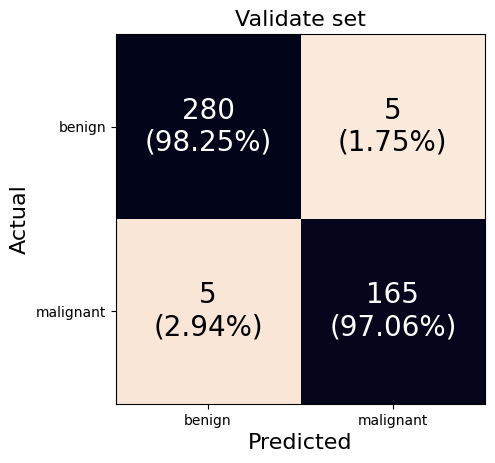

AUC5: 9925.70 ± 48.21%
../kitt/DATA_progress3_new//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.389105
FPR: 0.0351
TPR: 0.9706
../kitt/DATA_progress3_new//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.585393
FPR: 0.0175
TPR: 0.9706
../kitt/DATA_progress3_new//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best Threshold=0.570536
FPR: 0.0000
TPR: 0.9412
../kitt/DATA_progress3_new//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new//tes

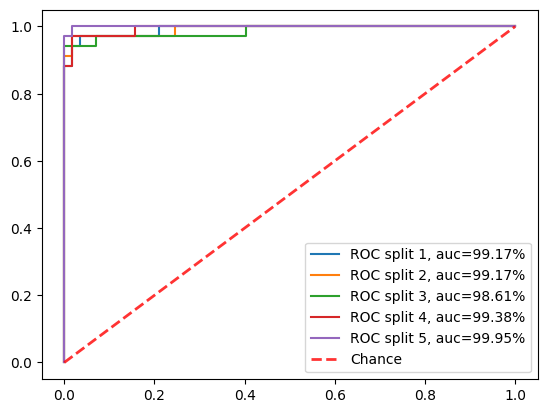

In [52]:
print("param5")
plot(param5_split1_cm_val , param5_split2_cm_val , param5_split3_cm_val , param5_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC5",param5_split1_AUC_val*100, param5_split2_AUC_val*100, param5_split3_AUC_val*100, param5_split4_AUC_val*100, param5_split5_AUC_val*100)
ROC_split(5)

# Final test (paaram4)

In [53]:
path = "../kitt/DATA_progress3_new/"
train_path = "{}/train.csv".format(path)
test_path =  "{}/test.csv".format(path)
print(train_path)
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)
print(test_path)
# Load the test set
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)
# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
# with open('ensemble_model/ensemble_final.txt', 'r') as f:
#     params_str = f.readline()
#     params_dict = eval(params_str)
#     f.close()
# print(params_dict)
# rf = RandomForestClassifier(bootstrap=params_dict["bootstrap"], 
#                        criterion=params_dict["criterion"], 
#                        max_depth=params_dict["max_depth"], 
#                        max_features=params_dict["max_features"], 
#                        min_samples_leaf=params_dict["min_samples_leaf"], 
#                        min_samples_split=params_dict["min_samples_split"], 
#                        n_estimators=params_dict["n_estimators"])
# def Ensemble_train(split):
# x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
# Define model
# SVM param
svm = SVC(C=100, gamma=0.001, kernel='rbf',probability=True)

# LR param5
lr = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')

# DT param1
dt = DecisionTreeClassifier(criterion="entropy",
                     max_depth=15, min_samples_leaf=1, 
                     min_samples_split=3, splitter="random")

# SGD param4
sgd = SGDClassifier(loss='log', penalty='l2', learning_rate='optimal', eta0=0.01, max_iter=1000, alpha=0.01)

# RF param4
# {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
rf = RandomForestClassifier(bootstrap=True, 
                    criterion="entropy", 
                    max_depth=10, 
                    max_features="log2", 
                    min_samples_leaf=1, 
                    min_samples_split=5, 
                    n_estimators=100)

svm.fit(x_train, y_train)
lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
sgd.fit(x_train, y_train)
rf.fit(x_train,y_train)

# create the voting ensemble model
ensemble = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('dt', dt), ('sgd', sgd), ('rf', rf)], voting='soft')
ensemble.fit(x_train, y_train)
# save the model
joblib.dump(ensemble, 'ensemble_model/ensemble_final.joblib')

# rf.fit(x_train, y_train)
# joblib.dump(rf, 'RF_model/RF_Final_test_param4.joblib')

../kitt/DATA_progress3_new//train.csv
(455, 18)
(455, 16)
['B' 'M']
../kitt/DATA_progress3_new//test.csv
(114, 18)
(114, 16)
['B' 'M']


['ensemble_model/ensemble_final.joblib']

################# test set ##################
Best Threshold=0.349187
FPR: 0.0278
TPR: 1.0000
Confusion Matrix
----------------
[[70  2]
 [ 0 42]] 

----------------
Sensitivity: 100.00%
Specificity: 97.22%
Accuracy: 98.25%
Precision: 95.45%
Sensitivity: 100.00%
Precision: 95.45%
F1: 97.67%


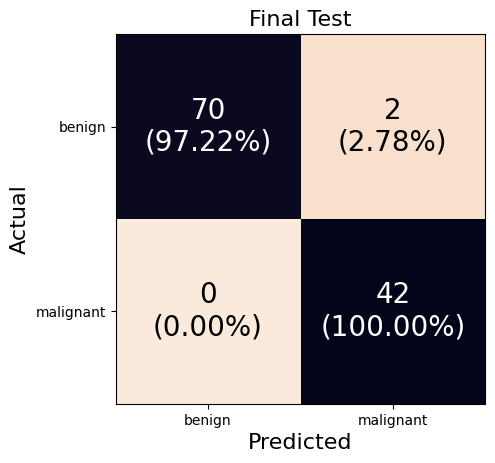

---------------------------------------
AUC test: 99.64%


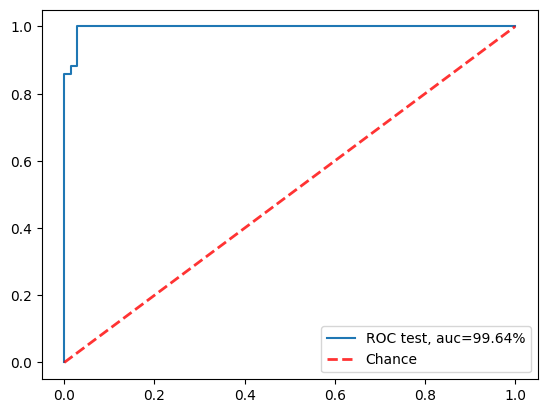

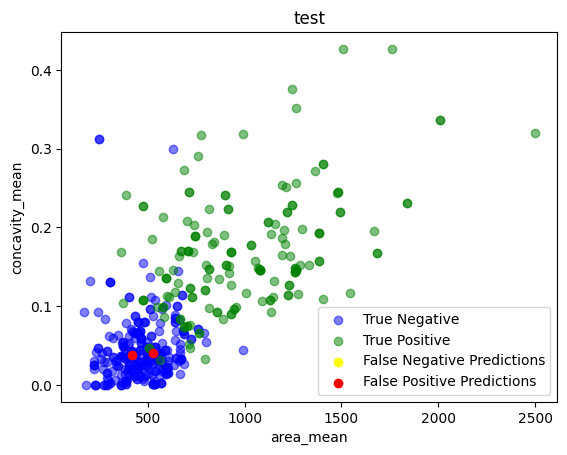

In [54]:
loaded_model = joblib.load('ensemble_model/ensemble_final.joblib')
# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test, title="Final", split="Test")

################## plot ROC curve ########################
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()
# feature_impotance(split)
split="test"
y_true = y_test
y_pred = y_pred_test
path = "../kitt/DATA_progress3/"
false_positive = []
false_negative = []

train_path = "{}/train.csv".format(path)
train_data = pd.read_csv(train_path)
test_path =  "{}/test.csv".format(path)
test_data = pd.read_csv(test_path)
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        if y_pred[i] == 1:
            false_positive.append(i)
        if y_pred[i] == 0:
            false_negative.append(i)
false_positive_df = test_data.loc[false_positive]
false_negative_df = test_data.loc[false_negative]
M_data = train_data[train_data["diagnosis"]=="M"]
B_data = train_data[train_data["diagnosis"]=="B"]
x_col, y_col = "area_mean" , "concavity_mean"
# Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
plt.scatter(B_data[x_col], B_data[y_col], color='blue', label='True Negative', alpha=0.5)
plt.scatter(M_data[x_col], M_data[y_col], color='green', label='True Positive', alpha=0.5)
plt.scatter(false_negative_df[x_col], false_negative_df[y_col], color='yellow', label='False Negative Predictions')
plt.scatter(false_positive_df[x_col], false_positive_df[y_col], color='red', label='False Positive Predictions') 
# Add legend and labels
plt.legend()
plt.title(split)
plt.xlabel(x_col)
plt.ylabel(y_col)
# Show the plot
plt.show()

# return cm_val,cm_test,auc1,auc2


In [58]:
false_predict_df(y_test, y_pred_test)

         id diagnosis  texture_mean  area_mean  smoothness_mean  \
20  9010872         B         18.29      838.1          0.09686   
33   905557         B         22.11      693.7          0.08515   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
20         0.05862         0.1495                 0.05593       1.439   
33         0.06859         0.1944                 0.05913       1.336   

    area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se  \
20    33.58       0.007257       0.01832      0.01694              0.002001   
33    28.51       0.004449       0.03312      0.01906              0.004015   

    smoothness_worst  concavity_worst  symmetry_worst  fractal_dimension_worst  
20            0.1338           0.1663          0.2394                  0.06469  
33            0.1077           0.3114          0.3163                  0.09251  


[20, 33]

# Font size

In [ ]:
# ############## validate set ################
# split = "split1"
# loaded_model = joblib.load('SVM_model-ROC/SVM_{}.joblib'.format(split))
# print("############## validate set ################")
# y_pred_val = loaded_model.predict_proba(x_val)

# # Confusion matrix
# cm_val = confusion_matrix(y_val, y_pred_val)
# print('Confusion Matrix')
# print('-'*16)
# print(cm_val,'\n')
# print('-'*16)

# # Calculate score
# print(split)
# sen_val = sensitivity(cm_val)
# spec_val = specificity(cm_val)
# acc_val = accuracy(cm_val)
# pre_val = precision(cm_val)
# f1_score_val = f1(cm_val)

# class_names = ['benign','malignant']
# # Normalize confusion matrix to percentage
# cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
# # Create plot with larger size
# fig, ax = plt.subplots(figsize=(8, 6))
# im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
# ax.grid(False)
# # Add labels
# ax.set(xticks=np.arange(cm_norm_val.shape[1]),
#        yticks=np.arange(cm_norm_val.shape[0]),
#        xticklabels=class_names, yticklabels=class_names)
# ax.set_title("Validate set", fontsize=16)
# ax.set_ylabel('Actual', fontsize=16)
# ax.set_xlabel('Predicted', fontsize=16)
        
# # Add percentage and count values inside plot
# thresh = cm_norm_val.max() / 2.
# for i in range(cm_norm_val.shape[0]):
#     for j in range(cm_norm_val.shape[1]):
#         ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
#                 ha="center", va="center",
#                 color="white" if cm_norm_val[i, j] > thresh else "black",
#                fontsize=24)
# plt.show()

# threshold

In [ ]:
# split_num = 1
# split = "split{}".format(split_num)
# x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

In [ ]:
# def plot_cm(cm_val, save=False):
#     class_names = ['benign','malignant']
#     # Normalize confusion matrix to percentage
#     cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
#     # Create plot
#     fig, ax = plt.subplots()
#     im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
#     ax.grid(False)
#     # Add labels
#     ax.set(xticks=np.arange(cm_norm_val.shape[1]),
#            yticks=np.arange(cm_norm_val.shape[0]),
#            xticklabels=class_names, yticklabels=class_names)
#     ax.set_title("Validate set", fontsize=16)
#     ax.set_ylabel('Actual', fontsize=16)
#     ax.set_xlabel('Predicted', fontsize=16)
#     # Add percentage and count values inside plot
#     thresh = cm_norm_val.max() / 2.
#     for i in range(cm_norm_val.shape[0]):
#         for j in range(cm_norm_val.shape[1]):
#             ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
#                     ha="center", va="center",
#                     color="white" if cm_norm_val[i, j] > thresh else "black",
#                    fontsize=20)
#     if save is not False:
#         save_path = '{}_{}.png'.format(split)
#         plt.savefig(save_path)
#         print("Save fig at {}".format(save_path))
#     plt.show()

In [ ]:
# param = 3
# param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

In [ ]:
# param = 1
# param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate_no_prob(param,split)

In [ ]:
# split_num = 1
# split = "split{}".format(split_num)
# x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
# param = 1
# param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)